In [1]:
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLines
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from scipy.optimize import curve_fit
from matplotlib import cm

In [2]:
def moving_average(a, n = 3, start_smooth = 100):
    a_start = a[:start_smooth]
    a_end = a[start_smooth:]
    ret = np.cumsum(a_end, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return np.concatenate((a_start, ret[n - 1:] / n))

In [3]:
def power_law_fit(x, a):
    ''' Use this to fit f^-2 (intermediate f) '''
    return a * x ** (-2)

In [4]:
# Plotting settings:
plt.rc('text', usetex=True)
plt.rc('font', size = 170, weight = 'bold')
plt.rc('lines', linewidth = 20)
plt.rcParams['xtick.major.width'] = 8
plt.rcParams['xtick.major.size'] = 30
plt.rcParams['xtick.labelsize'] = 170
plt.rcParams['ytick.major.width'] = 8
plt.rcParams['ytick.major.size'] = 30
plt.rcParams['ytick.labelsize'] = 170
plt.rc('axes', labelsize=170) 

## SFS

In [5]:
# import data

L = 500
rho = 20000
N = L * rho
s = 0.05
m = 0.25
tfinal = 1000000
Un = 1
r = 0
n_forward = 100
n = 100000
n_wellmixed = 10000
nSFS = 1000
nsim_wellmixed = 1000
tfix = 0

f = np.arange(1, n + 1) / n
f_wellmixed = np.arange(1, n_wellmixed + 1) / n_wellmixed
navg = 30
start_smooth = 100
f_short = moving_average(f, navg, start_smooth)

# Find v from lines

freq_file = open(
   'forward_simulation_data/L={}_N={}_s={:.6f}_m={:.6f}_tfinal={}_0.txt'.format(L, rho, s, m, tfinal))
lines = np.loadtxt(freq_file, dtype=np.int64)
tf_real = len(lines)
v_list = []
for t in np.arange(int(tf_real / 4), int(tf_real * 3 / 4)):
    line1 = lines[t]
    line2 = lines[t + 1]
    psum1 = sum(line1) / rho
    psum2 = sum(line2) / rho
    v_list.append(psum2 - psum1)

v = np.average(v_list)


SFS = np.loadtxt(
    'backward_simulation_data/expected_SFS_L={}_N={}_s={:.6f}_m={:.6f}_r={:.6f}_tfinal={}_nsample={}_tfix={}_sample_uniform_navg={}_avged.txt'.format(L, 
                 rho, s, m, r, tfinal, n, tfix, nSFS))


SFS_well_mixed = np.loadtxt('backward_simulation_data/expected_SFS_well_mixed_N={}_Tfix={}_s={:.2f}_r={:.2e}_nsample={}_nsim={}.txt'.format(
        N, tfix, s, r, n_wellmixed, nsim_wellmixed))
SFS_well_mixed2 = np.loadtxt('backward_simulation_data/expected_SFS_well_mixed_N={}_Tfix={}_s={:.2f}_r={:.2e}_nsample={}_nsim={}.txt'.format(
        N, tfix, s, r, n, 20))

f_wellmixed_combined = np.append(f[:78], f_wellmixed[8:])
SFS_wellmixed_combined = np.append(SFS_well_mixed2[:78], SFS_well_mixed[8:])

In [6]:
# smooth curves

smooth_SFS_wellmixed_combined = moving_average(SFS_wellmixed_combined, navg, start_smooth)
smooth_SFS = moving_average(SFS, navg, start_smooth)

## Overall allele frequency spectra

/Users/dbweiss/Library/Python/3.10/lib/python/site-packages/labellines/core.py:148: UserWarning: Tried to label line Line2D(_child4), but could not find a label for it.
  warnings.warn(
/Users/dbweiss/Library/Python/3.10/lib/python/site-packages/labellines/core.py:148: UserWarning: Tried to label line Line2D(_child6), but could not find a label for it.
  warnings.warn(
/Users/dbweiss/Library/Python/3.10/lib/python/site-packages/labellines/core.py:148: UserWarning: Tried to label line Line2D(_child10), but could not find a label for it.
  warnings.warn(


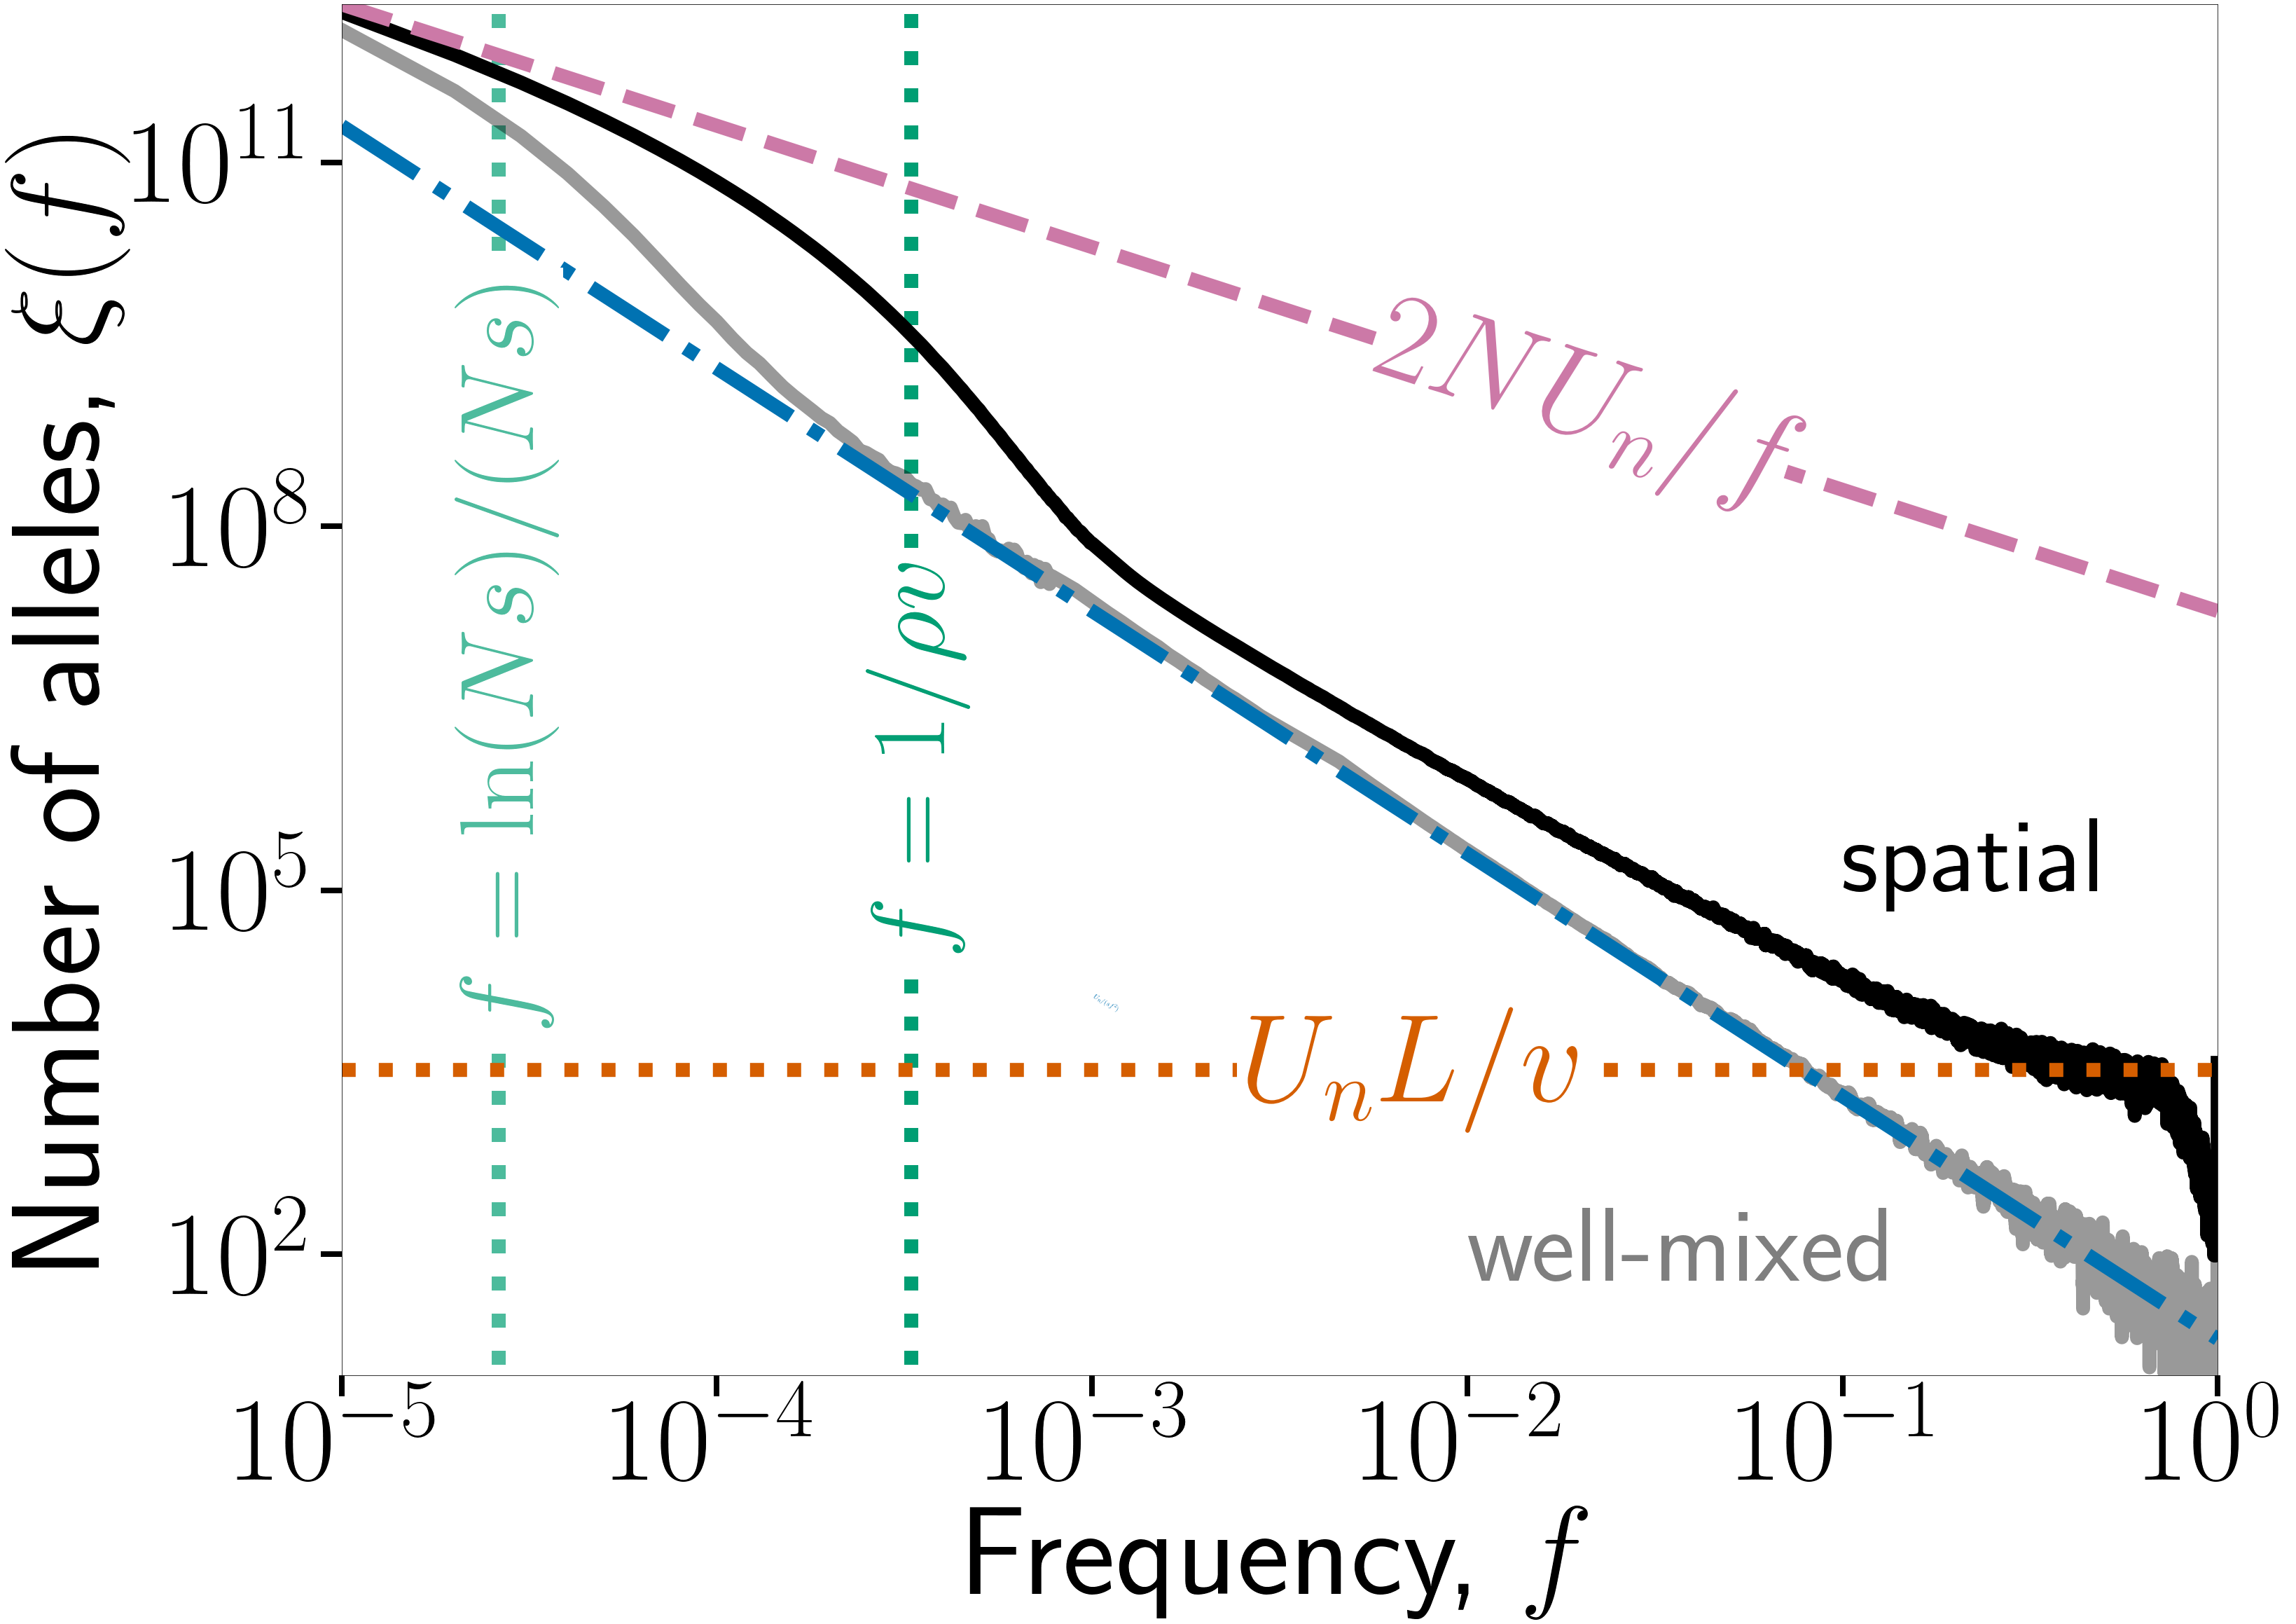

In [7]:
# plot the figure on a loglog scale

fig, ax = plt.subplots(figsize = (48,36))
ax.set_xlabel(r'Frequency, $f$', fontsize = 180)
ax.set_ylabel(r'Number of alleles, $\xi(f)$', fontsize = 180)

ax.vlines(np.log(N * s) / s / N, 10 ** (-2), 10 ** 15, linestyle = 'dotted', color = '#009e73', alpha = 0.7)
ax.text(2e-5, 1.2e4, r'$f = \ln(Ns) / (Ns)$', color = '#009e73', fontsize = 150, rotation = 90, 
         backgroundcolor = 'w', alpha = 0.7)


ax.vlines(1 / (rho * v), 10 ** (-2), 10 ** 15, linestyle = 'dotted', color = '#009e73')
ax.text(2.5e-4, 5e4, r'$f = 1 / \rho v$', color = '#009e73', fontsize = 150, rotation = 90, 
         backgroundcolor = 'w')

#plt.text(0.002, 3 * 10 ** 5, r'$U_n \ln( N s f) / (s f^2)$', color = '#0072b2', fontsize = 150, rotation = -25)
#        
ax.loglog(moving_average(f_wellmixed_combined, navg, start_smooth), smooth_SFS_wellmixed_combined, 
             color = 'k', alpha = 0.4)
ax.text(10 ** (-2), 60, 'well-mixed', color = 'k', alpha = 0.5, fontsize = 150, backgroundcolor = 'w')

ax.loglog(f_short, smooth_SFS, color = 'k')
ax.text(10 ** (-1), 10 ** 5, 'spatial', color = 'k', fontsize = 150, backgroundcolor = 'w')


ax.text(10 ** -3, 10 ** 4, r'$U_n / (sf^2)$',  color = '#0072b2', rotation = -29.5)
neutral, = ax.loglog(f_short, 2 * Un * rho * L * np.ones(len(f_short)) / f_short,
           label = r'$2 N U_n / f$', linestyle = '--', color = '#cc79a7')


ax.loglog(f_short, Un / s / f_short ** 2, linestyle = '-.', color = '#0072b2')


flat, = ax.semilogy(f_short, np.ones(len(f_short)) * L / v, linestyle = 'dotted',
              label = r'$U_n L / v$', color = '#d55e00')

ax.set_ylim((10, 2 * 10 ** 12))
ax.set_xlim((1e-5, 1))

plt.xticks(np.logspace(-5,0,6))
plt.yticks(np.logspace(2,11,4))

xvals = [0.02, 0.007]
labelLines(ax.get_lines(), xvals = xvals, fontsize = 180, backgroundcolor = 'w');

In [8]:
# save the figure

fig.savefig('asex_log.pdf', format = 'pdf', bbox_inches = 'tight')

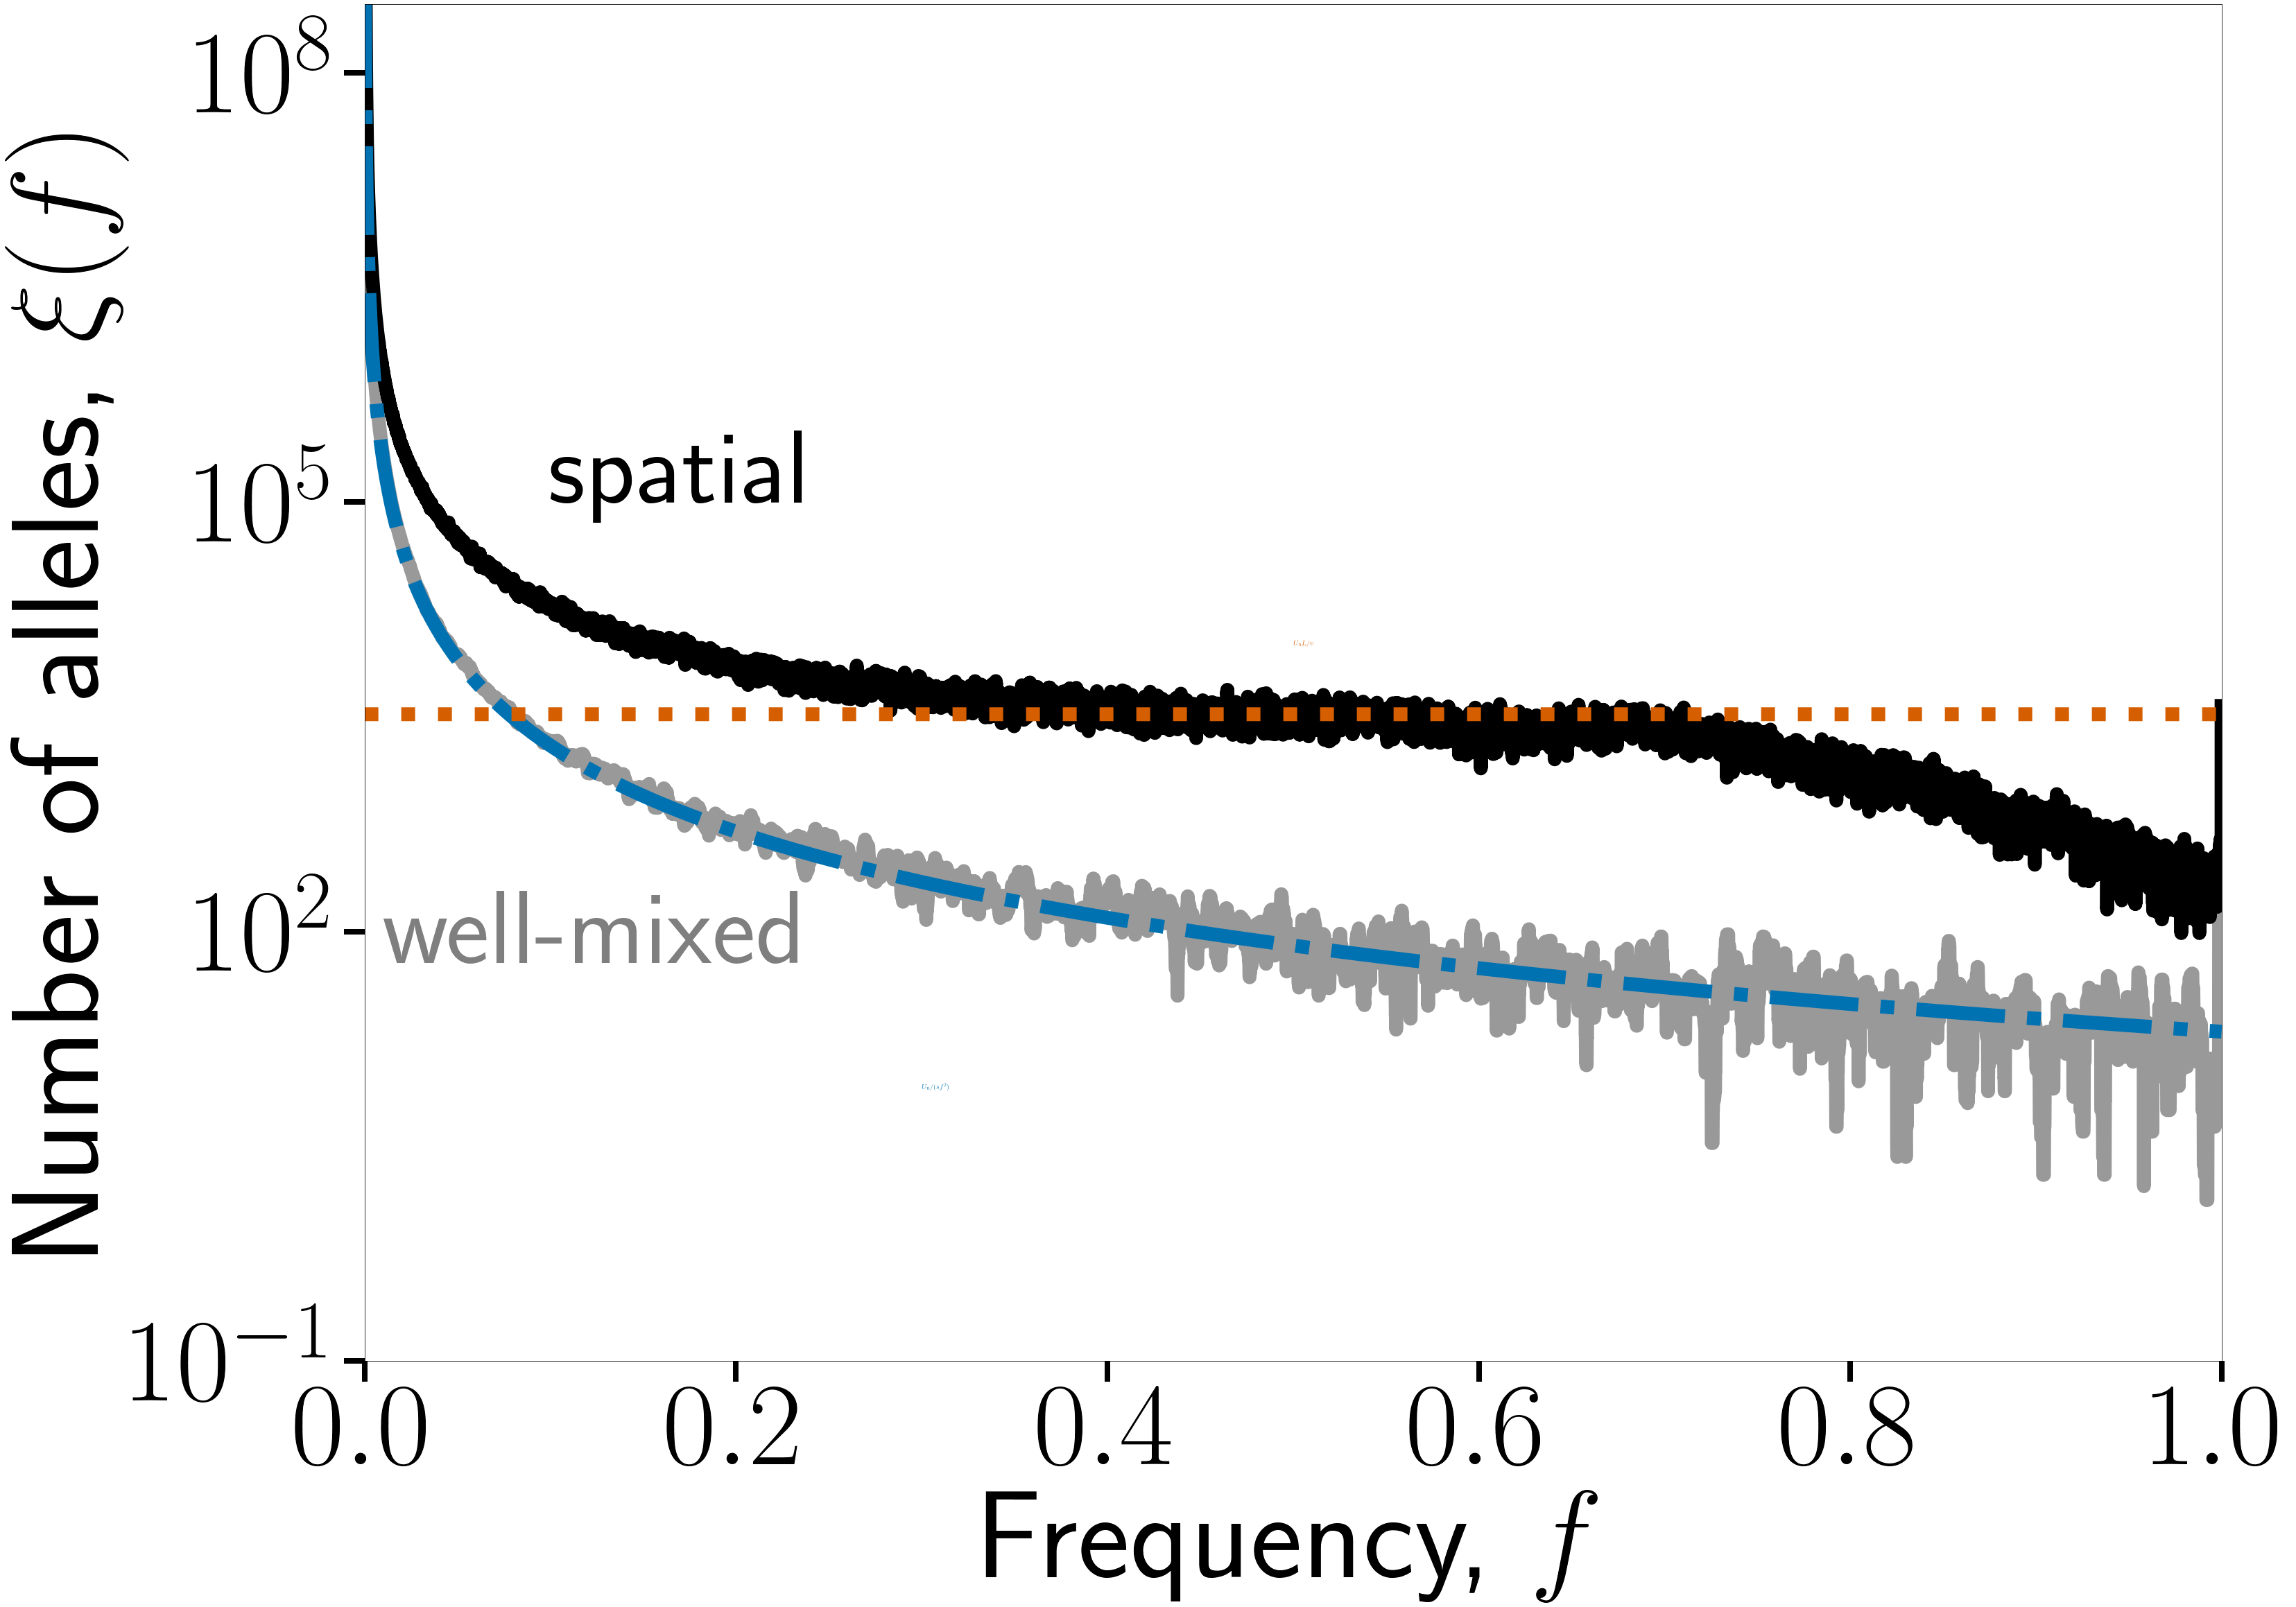

In [8]:
# plot the figure on a semi log y scale

fig, ax = plt.subplots(figsize = (48,36))
ax.set_xlabel(r'Frequency, $f$', fontsize = 180)
ax.set_ylabel(r'Number of alleles, $\xi(f)$', fontsize = 180)

ax.semilogy(moving_average(f_wellmixed_combined, navg, start_smooth), smooth_SFS_wellmixed_combined, 
             color = 'k', alpha = 0.4)
ax.text(10 ** (-2), 60, 'well-mixed', color = 'k', alpha = 0.5, fontsize = 150, backgroundcolor = 'w')

ax.semilogy(f_short, smooth_SFS, color = 'k')
ax.text(10 ** (-1), 10 ** 5, 'spatial', color = 'k', fontsize = 150, backgroundcolor = 'w')

ax.text(0.5, 10 ** 4, r'$U_n L / v$', color = '#d55e00')

ax.text(0.3, 8, r'$U_n / (sf^2)$', color = '#0072b2')

bsc, = ax.semilogy(f_short, Un / s / f_short ** 2, linestyle = '-.', color = '#0072b2', 
           label = r'$U_n / (sf^2)$')

flat, = ax.semilogy(f_short, np.ones(len(f_short)) * L / v, linestyle = 'dotted',
              label = r'$U_n L / v$', color = '#d55e00')

ax.set_ylim((10, 3 * 10 ** 8))
ax.set_xlim((1e-4, 1))

plt.xticks(np.linspace(1e-5,1,6))
plt.yticks(np.logspace(-1,8,4))

xvals = [0.02, 0.00005, 0.007]


In [10]:
# save the figure

fig.savefig('asex_linear.pdf', format = 'pdf', bbox_inches = 'tight')

 ## Allele frequency spectra just in the surfing range

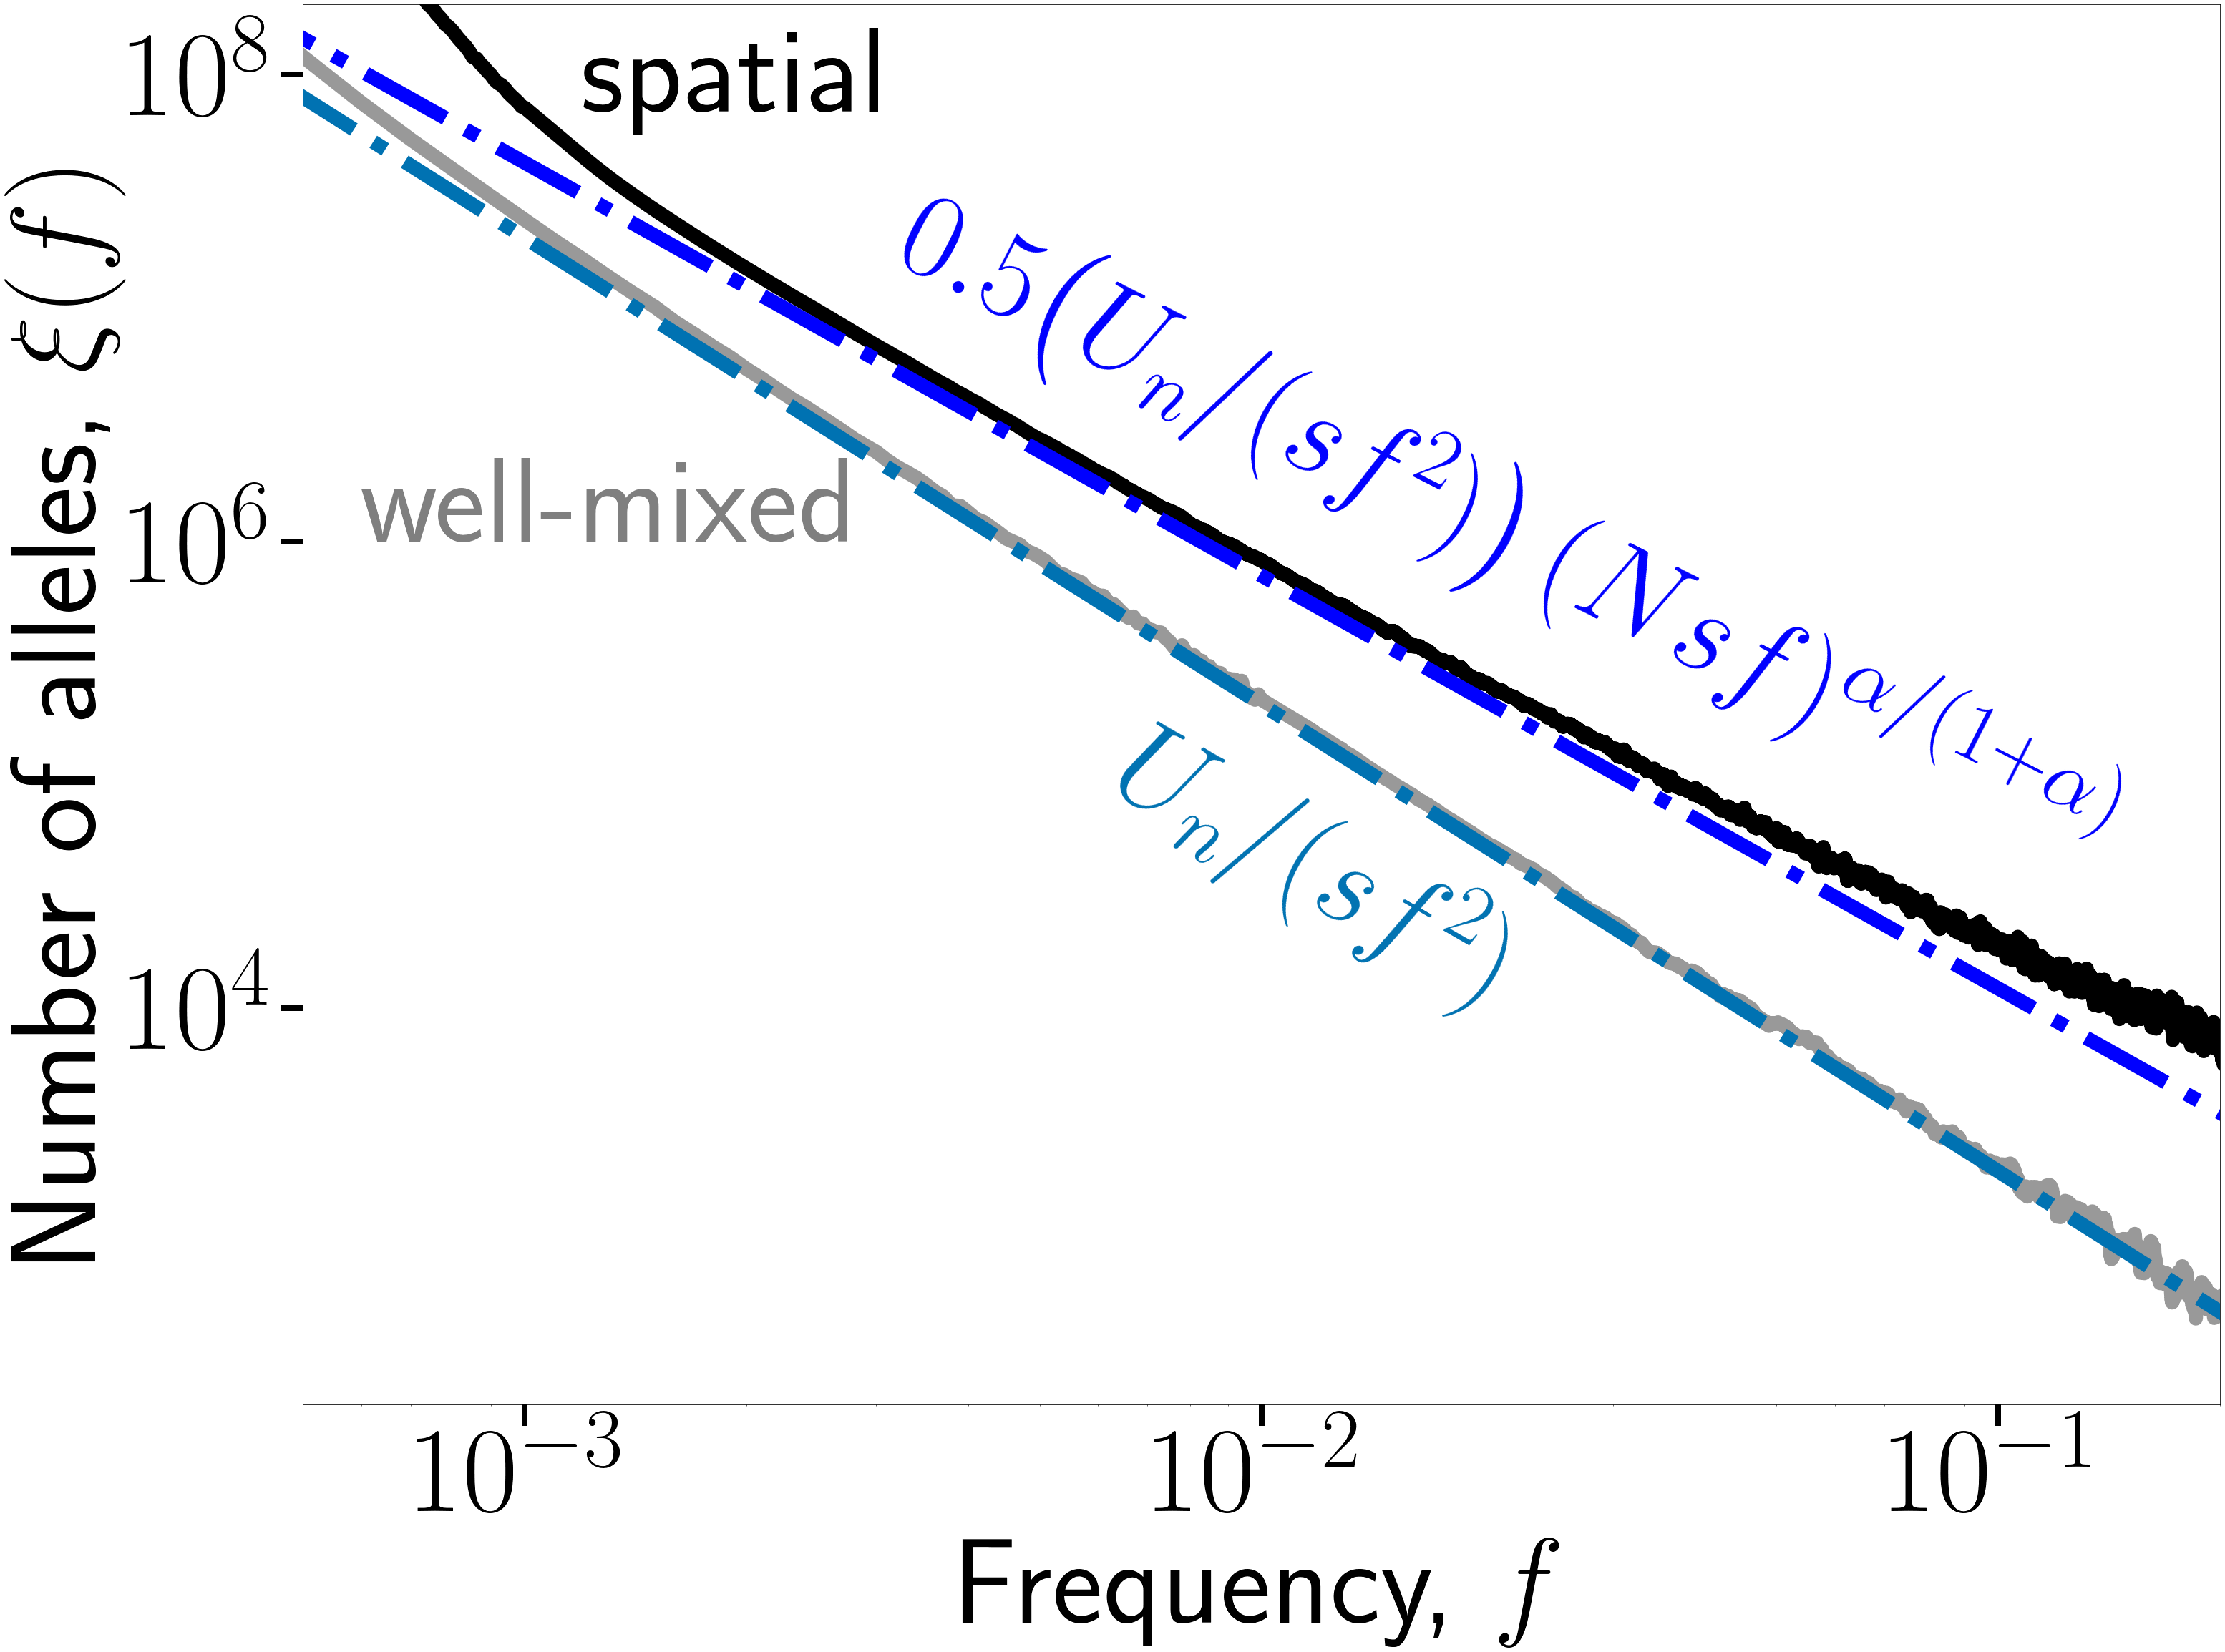

In [9]:
# plt.rc('font', family='serif', size = 150, weight = 'bold')
fig, ax = plt.subplots(figsize = (48, 36))
ax.set_xlabel(r'Frequency, $f$')
ax.set_ylabel(r'Number of alleles, $\xi(f)$')

ax.loglog(moving_average(f_wellmixed, navg, start_smooth), moving_average(SFS_well_mixed, navg, start_smooth), 
             color = 'k', alpha = 0.4)

ax.loglog(f_short, moving_average(SFS, navg, start_smooth), color = 'k')

ax.loglog(f_short, Un / s / f_short ** 2, linestyle = '-.', color = '#0072b2', label = r'$U_n / (sf^2)$')
# bsc2, = ax.loglog(f_short, Un * np.log(N * s * f_short)**3 * np.sqrt(m) / s**(3 / 2) / f_short**2 / L , 
#            linestyle = '-.', linewidth = 12, color = 'b', label = r'$\boldmath{U_n \ln(Nsf)^3 \sqrt{m} / (L s^{3/2} f^2)}$')

alpha = 0.30
prefactor = 0.5
ax.loglog(f_short, prefactor * Un * ((rho * L)**alpha / s / f_short**(2 + alpha))**(1 / (1 + alpha)),
          linestyle = '-.', color = 'b')

ax.text(1.2e-3, 7e7, 'spatial', color = 'k', fontsize = 170)
ax.text(6e-4, 1e6, 'well-mixed', color = 'k', alpha = 0.5, fontsize = 170)
ax.text(3e-3, 4e4, '${}$'.format(prefactor) + r'$\left(U_n / (s f^2)\right) (N s f)^{\alpha / (1 + \alpha)}$',  
         color = 'b', fontsize = 170, rotation=-27)
ax.text(6e-3, 1e4, r'$U_n/(s f^2)$', color = '#0072b2', fontsize = 170, rotation=-30)

ax.set_xlim((5 * 10 ** -4, 2 * 10 ** -1))
ax.set_ylim((200, 2 * 10 ** 8));

In [12]:
# save the figure
fig.savefig('intermediate_freq.pdf', format = 'pdf', bbox_inches = 'tight')

# Showing the collapse of different parameter combinations for surfing SFS

In [10]:
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size = 60, weight = 'bold')
Un = 1
r = 0
n_forward = 100
tfix = 0

n = 100000
nSFS = 1000

blue_cmap = cm.get_cmap('Blues')
red_cmap = cm.get_cmap('Reds')
grey_cmap = cm.get_cmap('Greys')
viridis_cmap = cm.get_cmap('viridis')

slist = np.arange(0.02, 0.07, 0.01)
mlist = np.arange(0.2, 0.55, 0.05)
Lrholist = [[500, 2000], [500, 20000], [1000, 10000], [1000, 1000], [2000, 5000], [5000, 2000]]
tfinallist = [10000, 1000000, 100000, 100000, 100000, 100000, 100000]

f = np.arange(1, n + 1) / n
navg = 30
start_smooth = 100
f_short = moving_average(f, navg, start_smooth)

fit_range_ind = np.arange(200,1000)

In [11]:
# Define a scaling factor here. 

def scale(L, rho, s, m, f, alpha=0.33):
    ''' scaling factor to collapse surfing SFSs.'''
    return(s / (L * rho * s)**(alpha / (1 + alpha)) / Un)

scale_label = r'$\xi(f) / \left[(U_n /s) (N s)^\frac{\alpha}{1 + \alpha}\right]$'

In [12]:
# import data for varying s

m = 0.25
L = 500
rho = 20000
N = rho * L
tfinal = 1000000

filenames = ['backward_simulation_data/expected_SFS_L={}_N={}_s={:.6f}_m={:.6f}_r={:.6f}_tfinal={}_nsample={}_tfix={}_sample_uniform_navg={}_avged.txt'.format(L, 
                 rho, s, m, r, tfinal, n, tfix, nSFS) for s in slist]
svar_smooth_SFS = [moving_average(np.loadtxt(filenames[sind]), navg, start_smooth) for sind, s in enumerate(slist)]

svar_fstart_ind = [int(10 / (rho * np.sqrt(m * s)) * n) for s in slist]

svar_scaling = [scale(L, rho, s, m, f_short) for s in slist] 

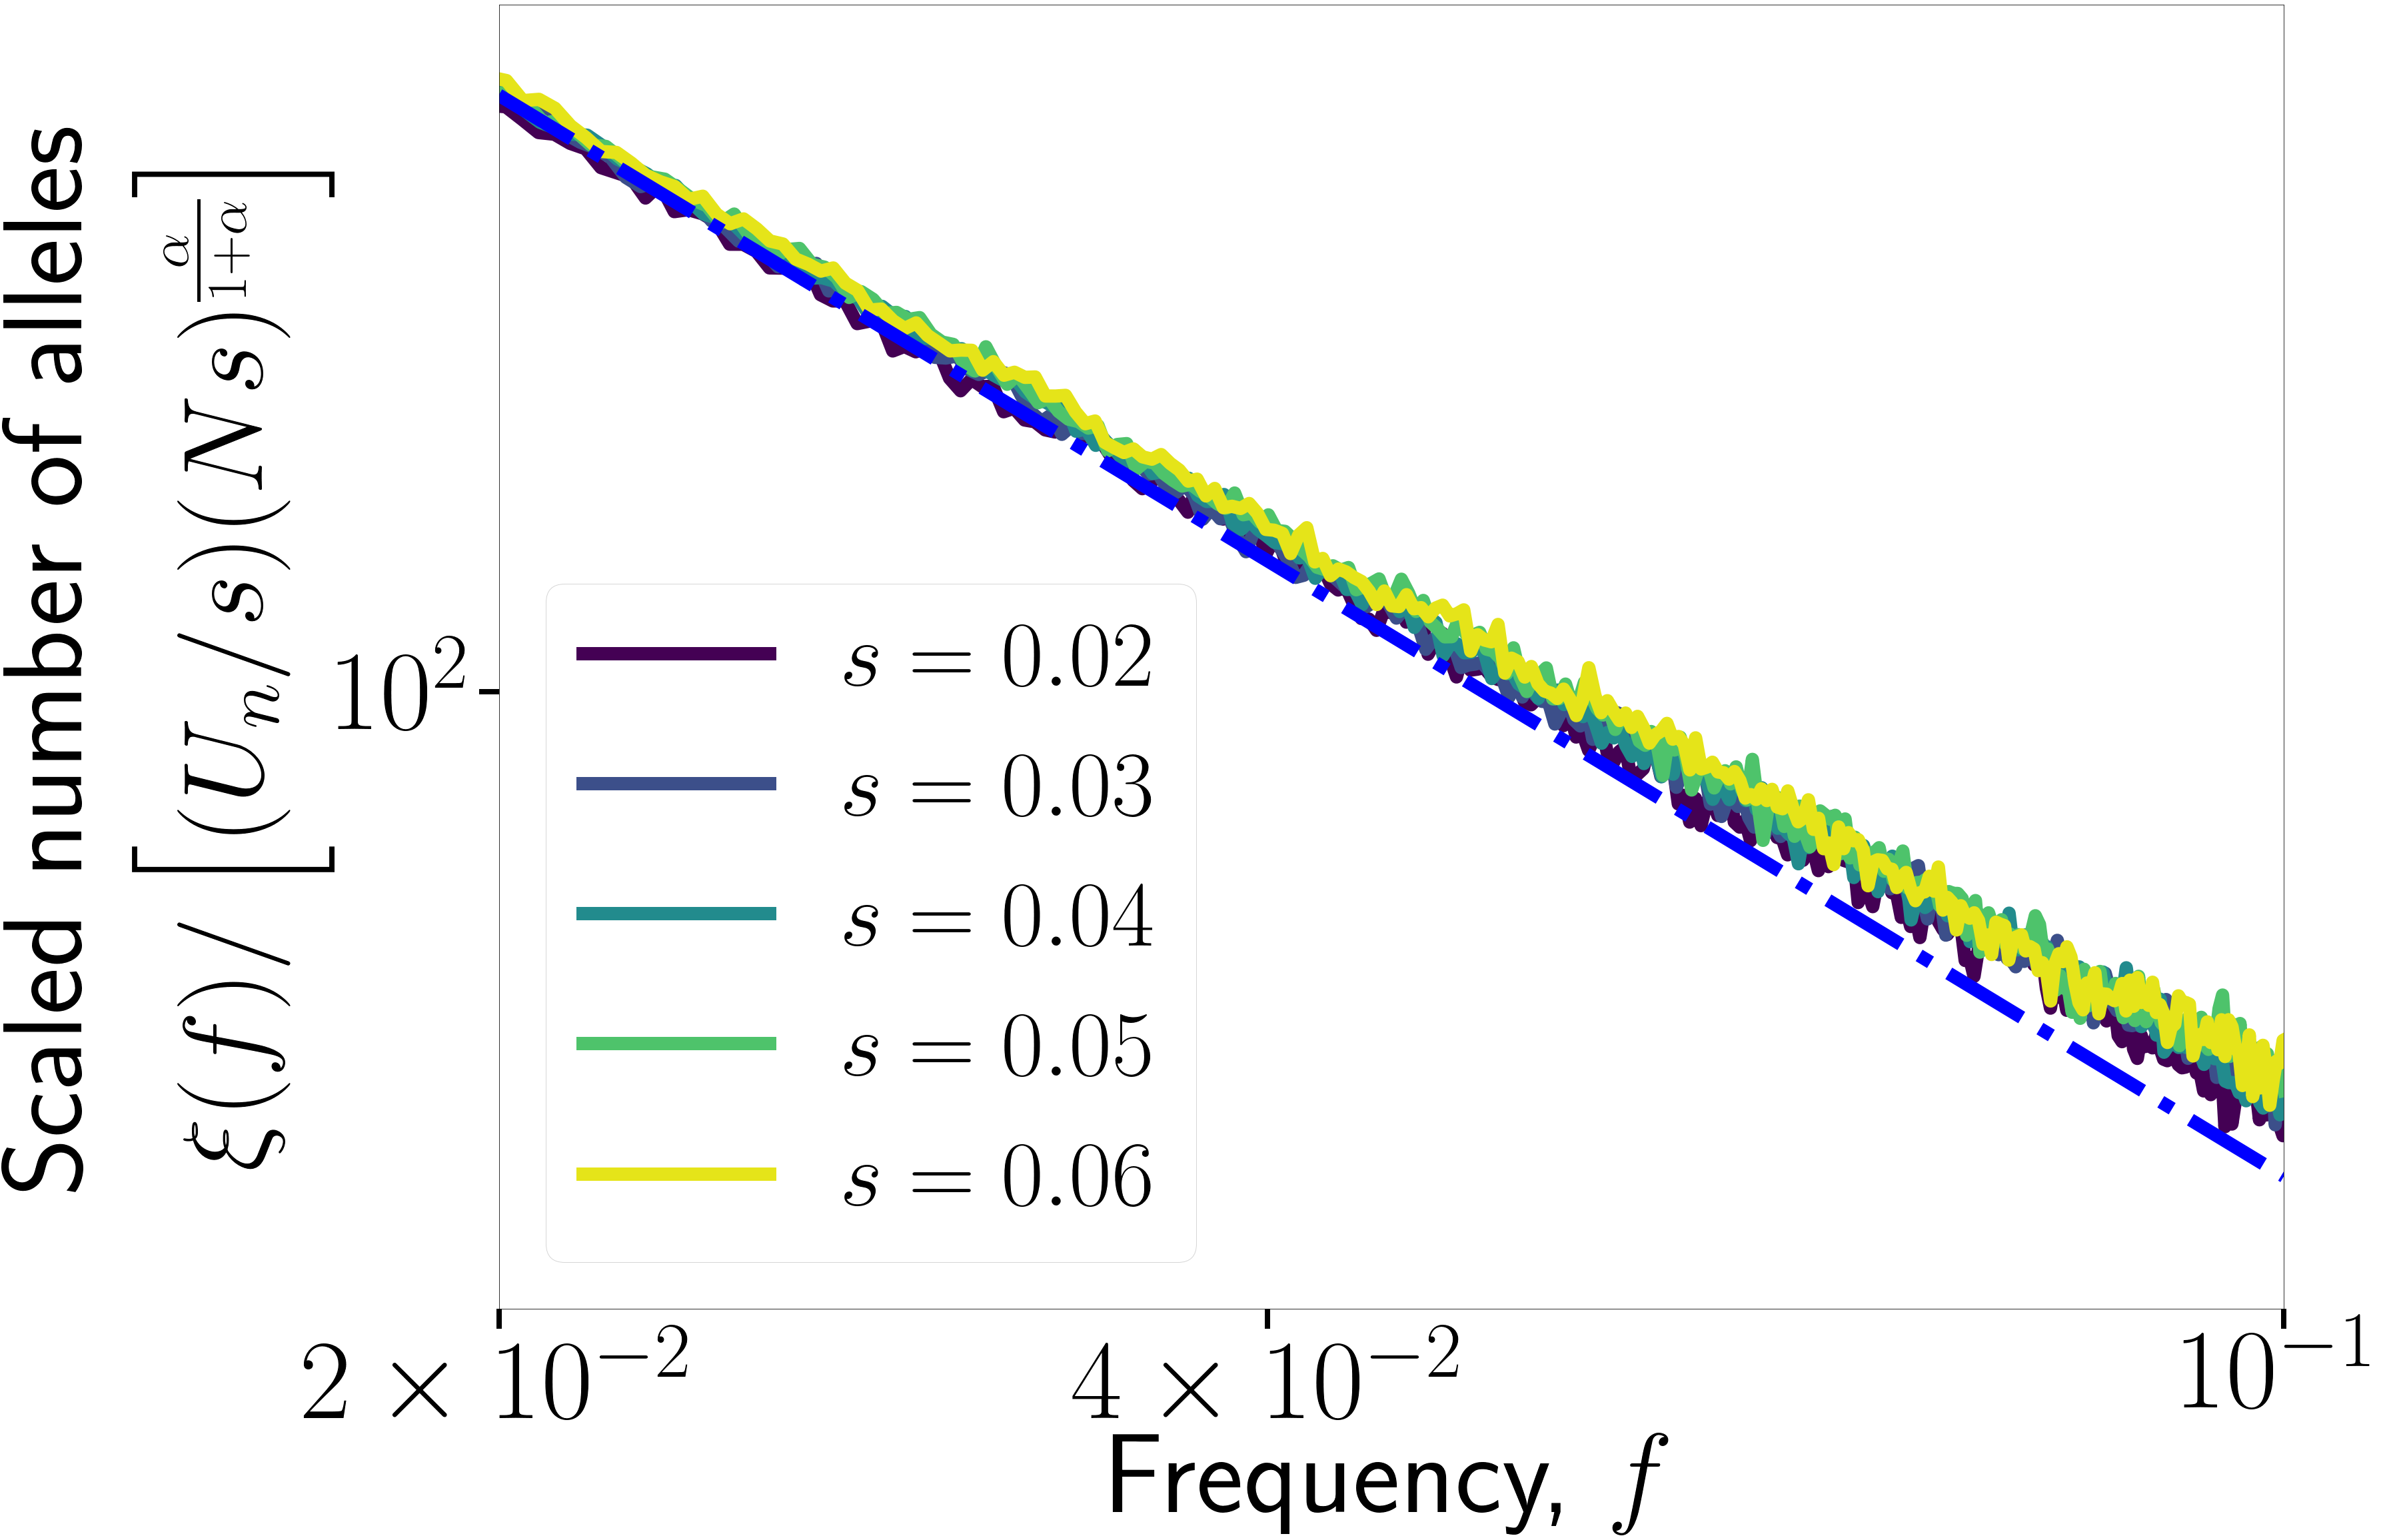

In [13]:
# plot just the varying s:

prefactor = 0.5
alpha = 0.33

fig, ax = plt.subplots(figsize = (48, 36));
for i, sfs in enumerate(svar_smooth_SFS):
    ax.plot(f_short[svar_fstart_ind[i]::30], 
            sfs[svar_fstart_ind[i]::30] * svar_scaling[i], 
             label=r'$s = {:.2f}$'.format(slist[i]), color = viridis_cmap(0.24 * i))
plt.legend(fontsize=140)    
ax.plot(f_short, prefactor * f_short**-((2 + alpha) / (1 + alpha)), '-.', c='b', 
       label =r'$0.5 f^{- (\alpha + 2) / (\alpha + 1)}$')

ax.loglog()
ax.set_xlim((2e-2, 1e-1))
ax.set_ylim((20, 600))
plt.xticks((2e-2, 4e-2, 1e-1))
ax.set_xlabel('Frequency, ' + r'$\boldmath{f}$')
ax.set_ylabel('Scaled number of alleles\n'+ scale_label)
plt.minorticks_off()


In [17]:
# save figure:
fig.savefig('vary_s.pdf', format = 'pdf', bbox_inches = 'tight')

In [14]:
# import data for varying m

s = 0.05
L = 500
rho = 20000
tfinal = 1000000

filenames = ['backward_simulation_data/expected_SFS_L={}_N={}_s={:.6f}_m={:.6f}_r={:.6f}_tfinal={}_nsample={}_tfix={}_sample_uniform_navg={}_avged.txt'.format(L, 
                 rho, s, m, r, tfinal, n, tfix, nSFS) for m in mlist]
mvar_smooth_SFS = [moving_average(np.loadtxt(filenames[mind]), navg, start_smooth) for mind, m in enumerate(mlist)]

mvar_fstart_ind = [int(10 / (rho * np.sqrt(m * s)) * n) for m in mlist]

mvar_scaling = [scale(L, rho, s, m, f_short) for m in mlist]


Text(0, 0.5, 'Scaled number of alleles\n$\\xi(f) / \\left[(U_n /s) (N s)^\\frac{\\alpha}{1 + \\alpha}\\right]$')

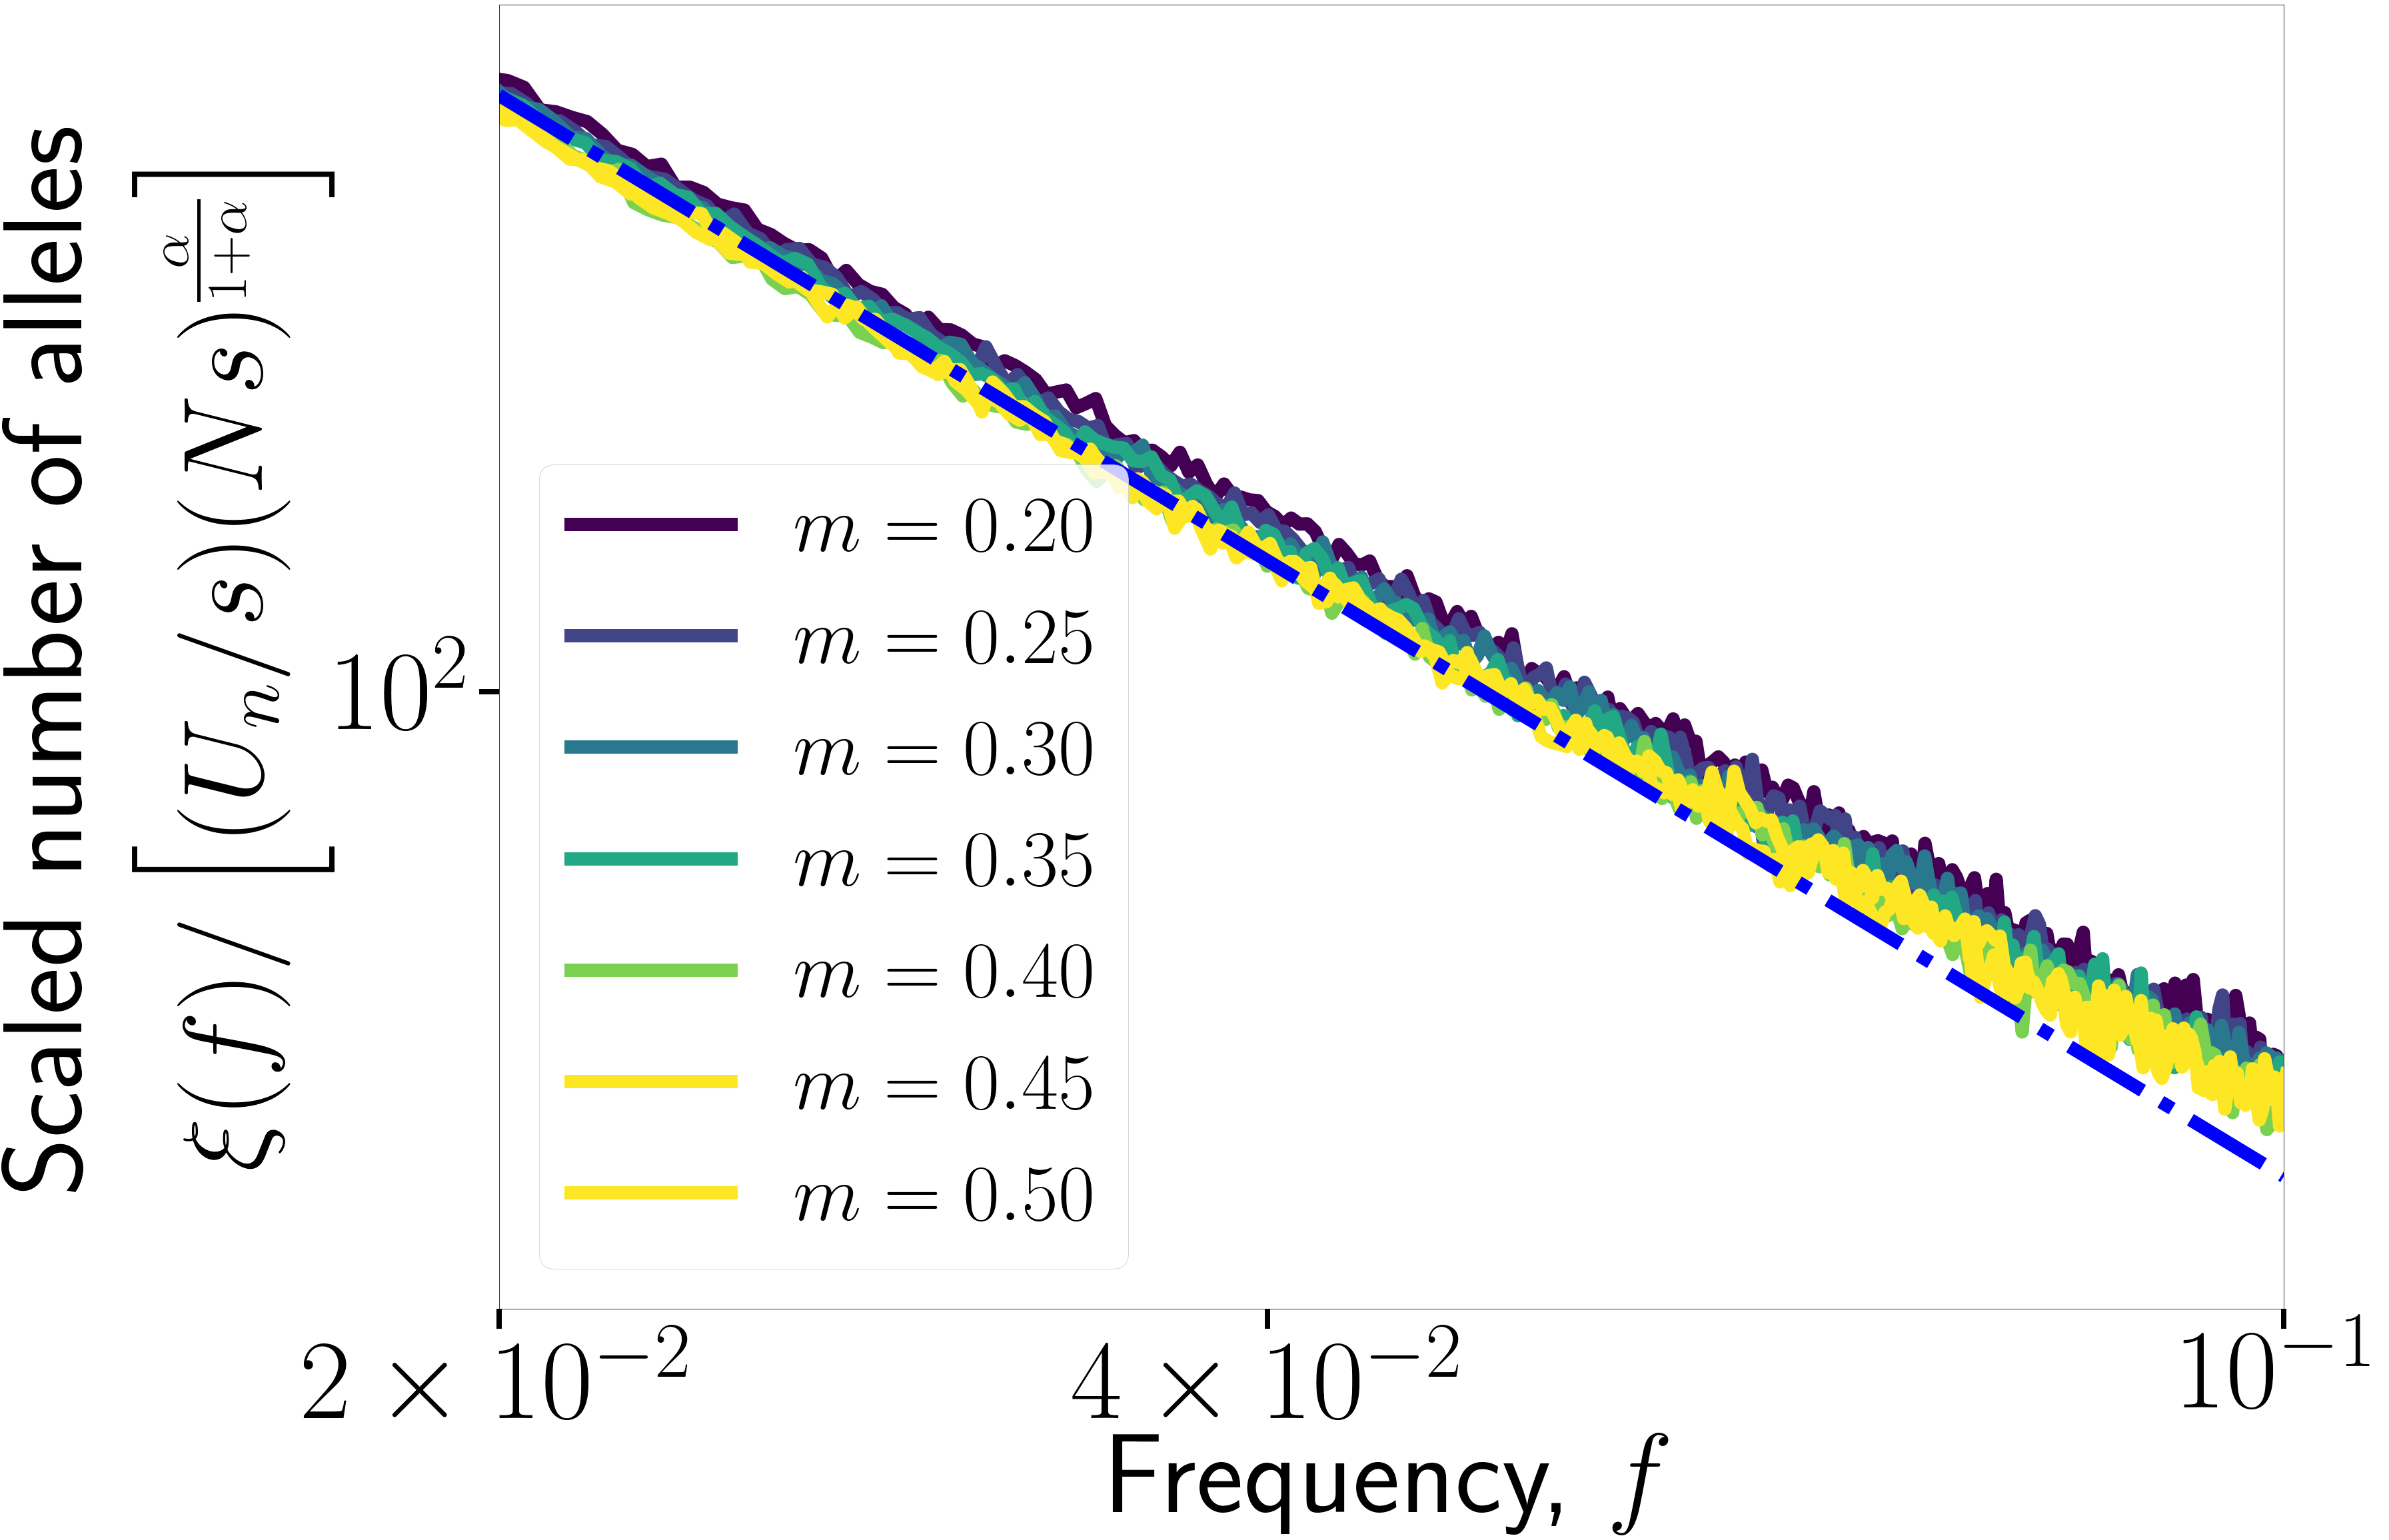

In [15]:

fig, ax = plt.subplots(figsize = (48, 36));
for i, sfs in enumerate(mvar_smooth_SFS):
    ax.plot(f_short[mvar_fstart_ind[i]::30], 
            sfs[mvar_fstart_ind[i]::30] * mvar_scaling[i], 
            label=r'$m = {:.2f}$'.format(mlist[i]), color = viridis_cmap(i * 0.2))
plt.legend(fontsize=120)    

ax.plot(f_short, prefactor * f_short**-((2 + alpha) / (1 + alpha)), '-.', c='b')


ax.loglog()
ax.set_xlim((2e-2, 1e-1))
ax.set_ylim((20, 600))
plt.xticks((2e-2, 4e-2, 1e-1))
plt.minorticks_off()
ax.set_xlabel('Frequency, ' + r'$\boldmath{f}$')
ax.set_ylabel('Scaled number of alleles\n'+ scale_label) 

In [20]:
# save figure:
fig.savefig('vary_m.pdf', format = 'pdf', bbox_inches = 'tight')

In [16]:
# import data for varying L and rho

s = 0.05
m = 0.25

filenames = ['backward_simulation_data/expected_SFS_L={}_N={}_s={:.6f}_m={:.6f}_r={:.6f}_tfinal={}_nsample={}_tfix={}_sample_uniform_navg={}_avged.txt'.format(Lrho[0], 
                 Lrho[1], s, m, r, tfinallist[ind], n, tfix, nSFS) for ind, Lrho in enumerate(Lrholist)]
Lrhovar_smooth_SFS = [moving_average(np.loadtxt(filenames[ind]), navg, start_smooth) for ind, Lrho in enumerate(Lrholist)]

Lrhovar_fstart_ind = [int(10 / (Lrho[1] * np.sqrt(m * s)) * n) for Lrho in Lrholist]

Lrhovar_lines = []

Lrhovar_marker = []
for Lrho in Lrholist:
    N = Lrho[0] * Lrho[1]
    if int(N) == int(10 ** 5):
        Lrhovar_marker.append('o')
    elif int(N) == int(10 ** 6):
        Lrhovar_marker.append('x')
    elif int(N) == int(10 ** 7):
        Lrhovar_marker.append('v')
    

Text(0, 0.5, 'Scaled number of alleles\n$\\xi(f) / \\left[(U_n /s) (N s)^\\frac{\\alpha}{1 + \\alpha}\\right]$')

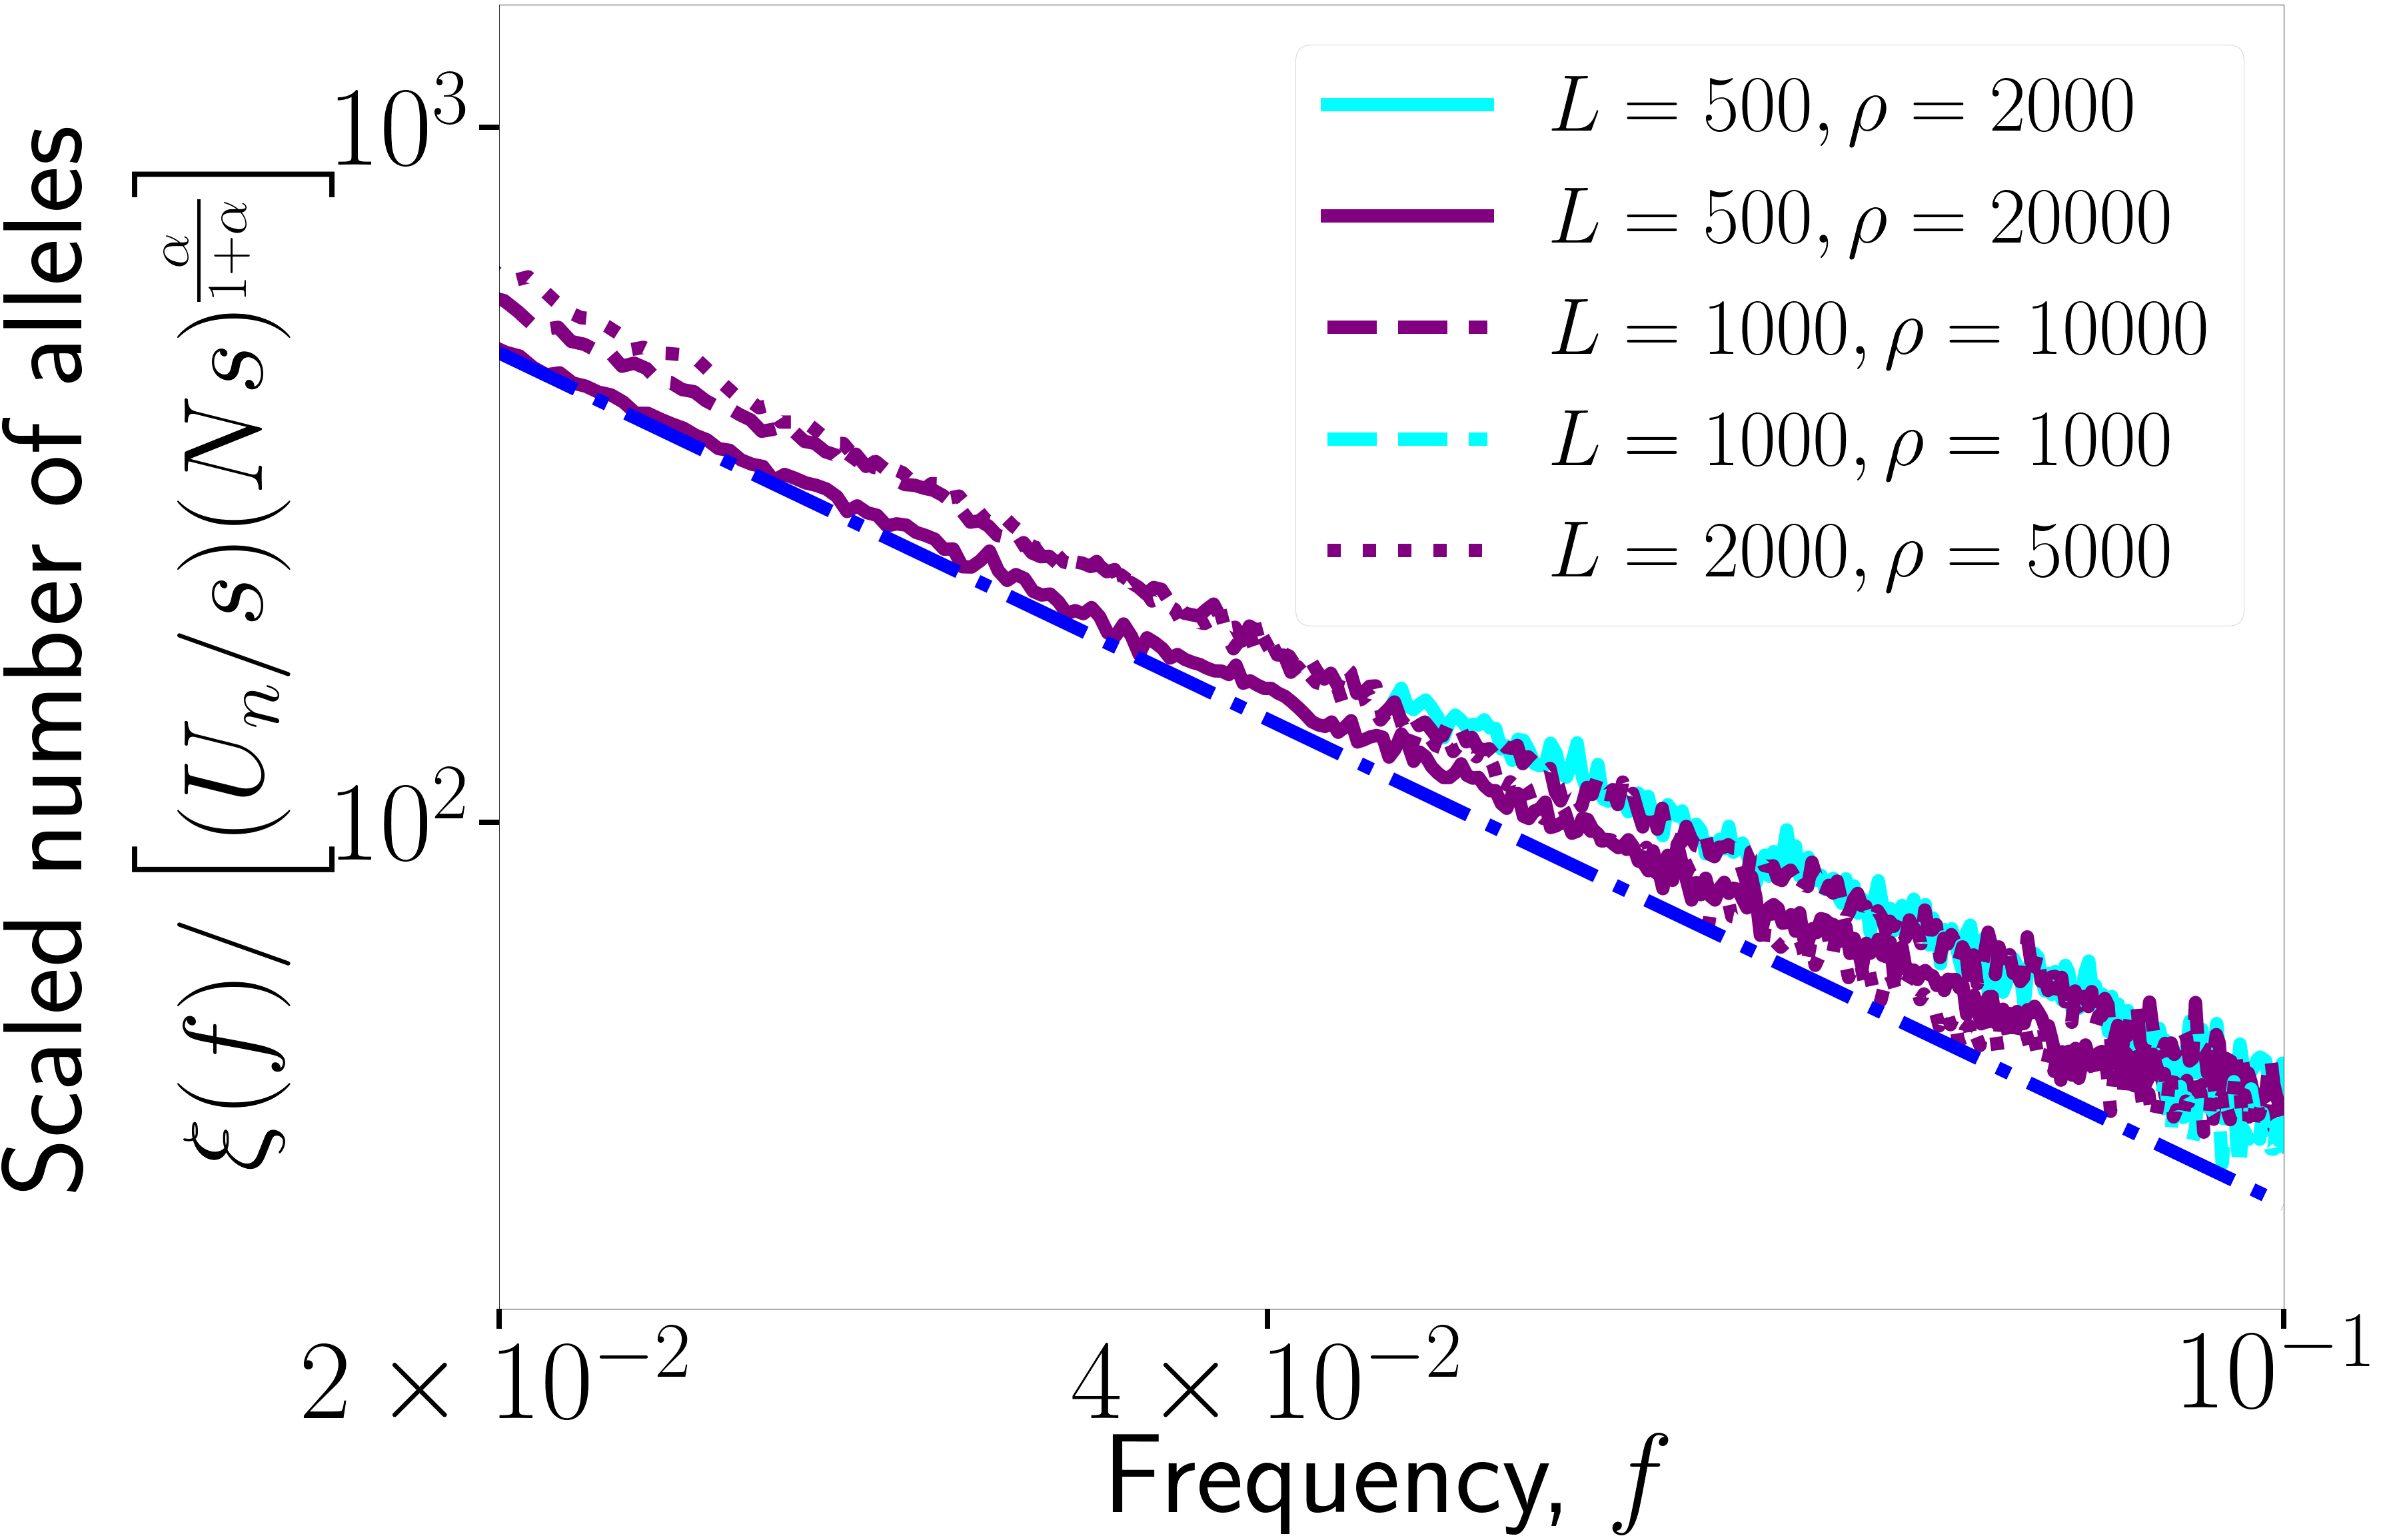

In [17]:
# plot just the varying L and rho:

def Lrhovar_line(L):
    if L==2000:
        return ':'
    if L==1000:
        return '--'
    if L == 500:
        return '-'
    
def Lrho_var_color(Lrho):
    N = Lrho[0] * Lrho[1]
    if N == 1e6:
        return 'cyan'
    if N == 1e7:
        return 'purple'

fig, ax = plt.subplots(figsize = (48, 36));

Lrhovar_scaling = [scale(Lrho[0], Lrho[1], s, m, f_short, 0.33) for Lrho in Lrholist] 

for i, sfs in enumerate(Lrhovar_smooth_SFS[:-1]):
    ax.plot(f_short[Lrhovar_fstart_ind[i]::25], 
            sfs[Lrhovar_fstart_ind[i]::25] * Lrhovar_scaling[i], Lrhovar_line(Lrholist[i][0]),
    label=r'$L={}, \rho={}$'.format(Lrholist[i][0], Lrholist[i][1]), 
            color = Lrho_var_color(Lrholist[i]))
plt.legend(fontsize=120)    

ax.plot(f_short, prefactor * f_short**-((2 + alpha) / (1 + alpha)), '-.', c='b')


ax.loglog()
ax.set_xlim((2e-2, 1e-1))
ax.set_ylim((20, 1500))
plt.xticks((2e-2, 4e-2, 1e-1))
plt.minorticks_off()
ax.set_xlabel('Frequency, ' + r'$\boldmath{f}$')
ax.set_ylabel('Scaled number of alleles\n'+scale_label)


In [23]:
# save figure:
fig.savefig('vary_Lrho.pdf', format = 'pdf', bbox_inches = 'tight')

### Uniform tail

In [18]:
def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if exponent is None:
        exponent = int(np.log10(abs(num))) - 1
    coeff = round(num / float(10**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

    return r"${0:.{2}f}\times10^{{{1:d}}}$".format(coeff, exponent, precision)

/Users/dbweiss/Library/Python/3.10/lib/python/site-packages/labellines/core.py:148: UserWarning: Tried to label line Line2D(_child3), but could not find a label for it.
  warnings.warn(


(1e-05, 1)

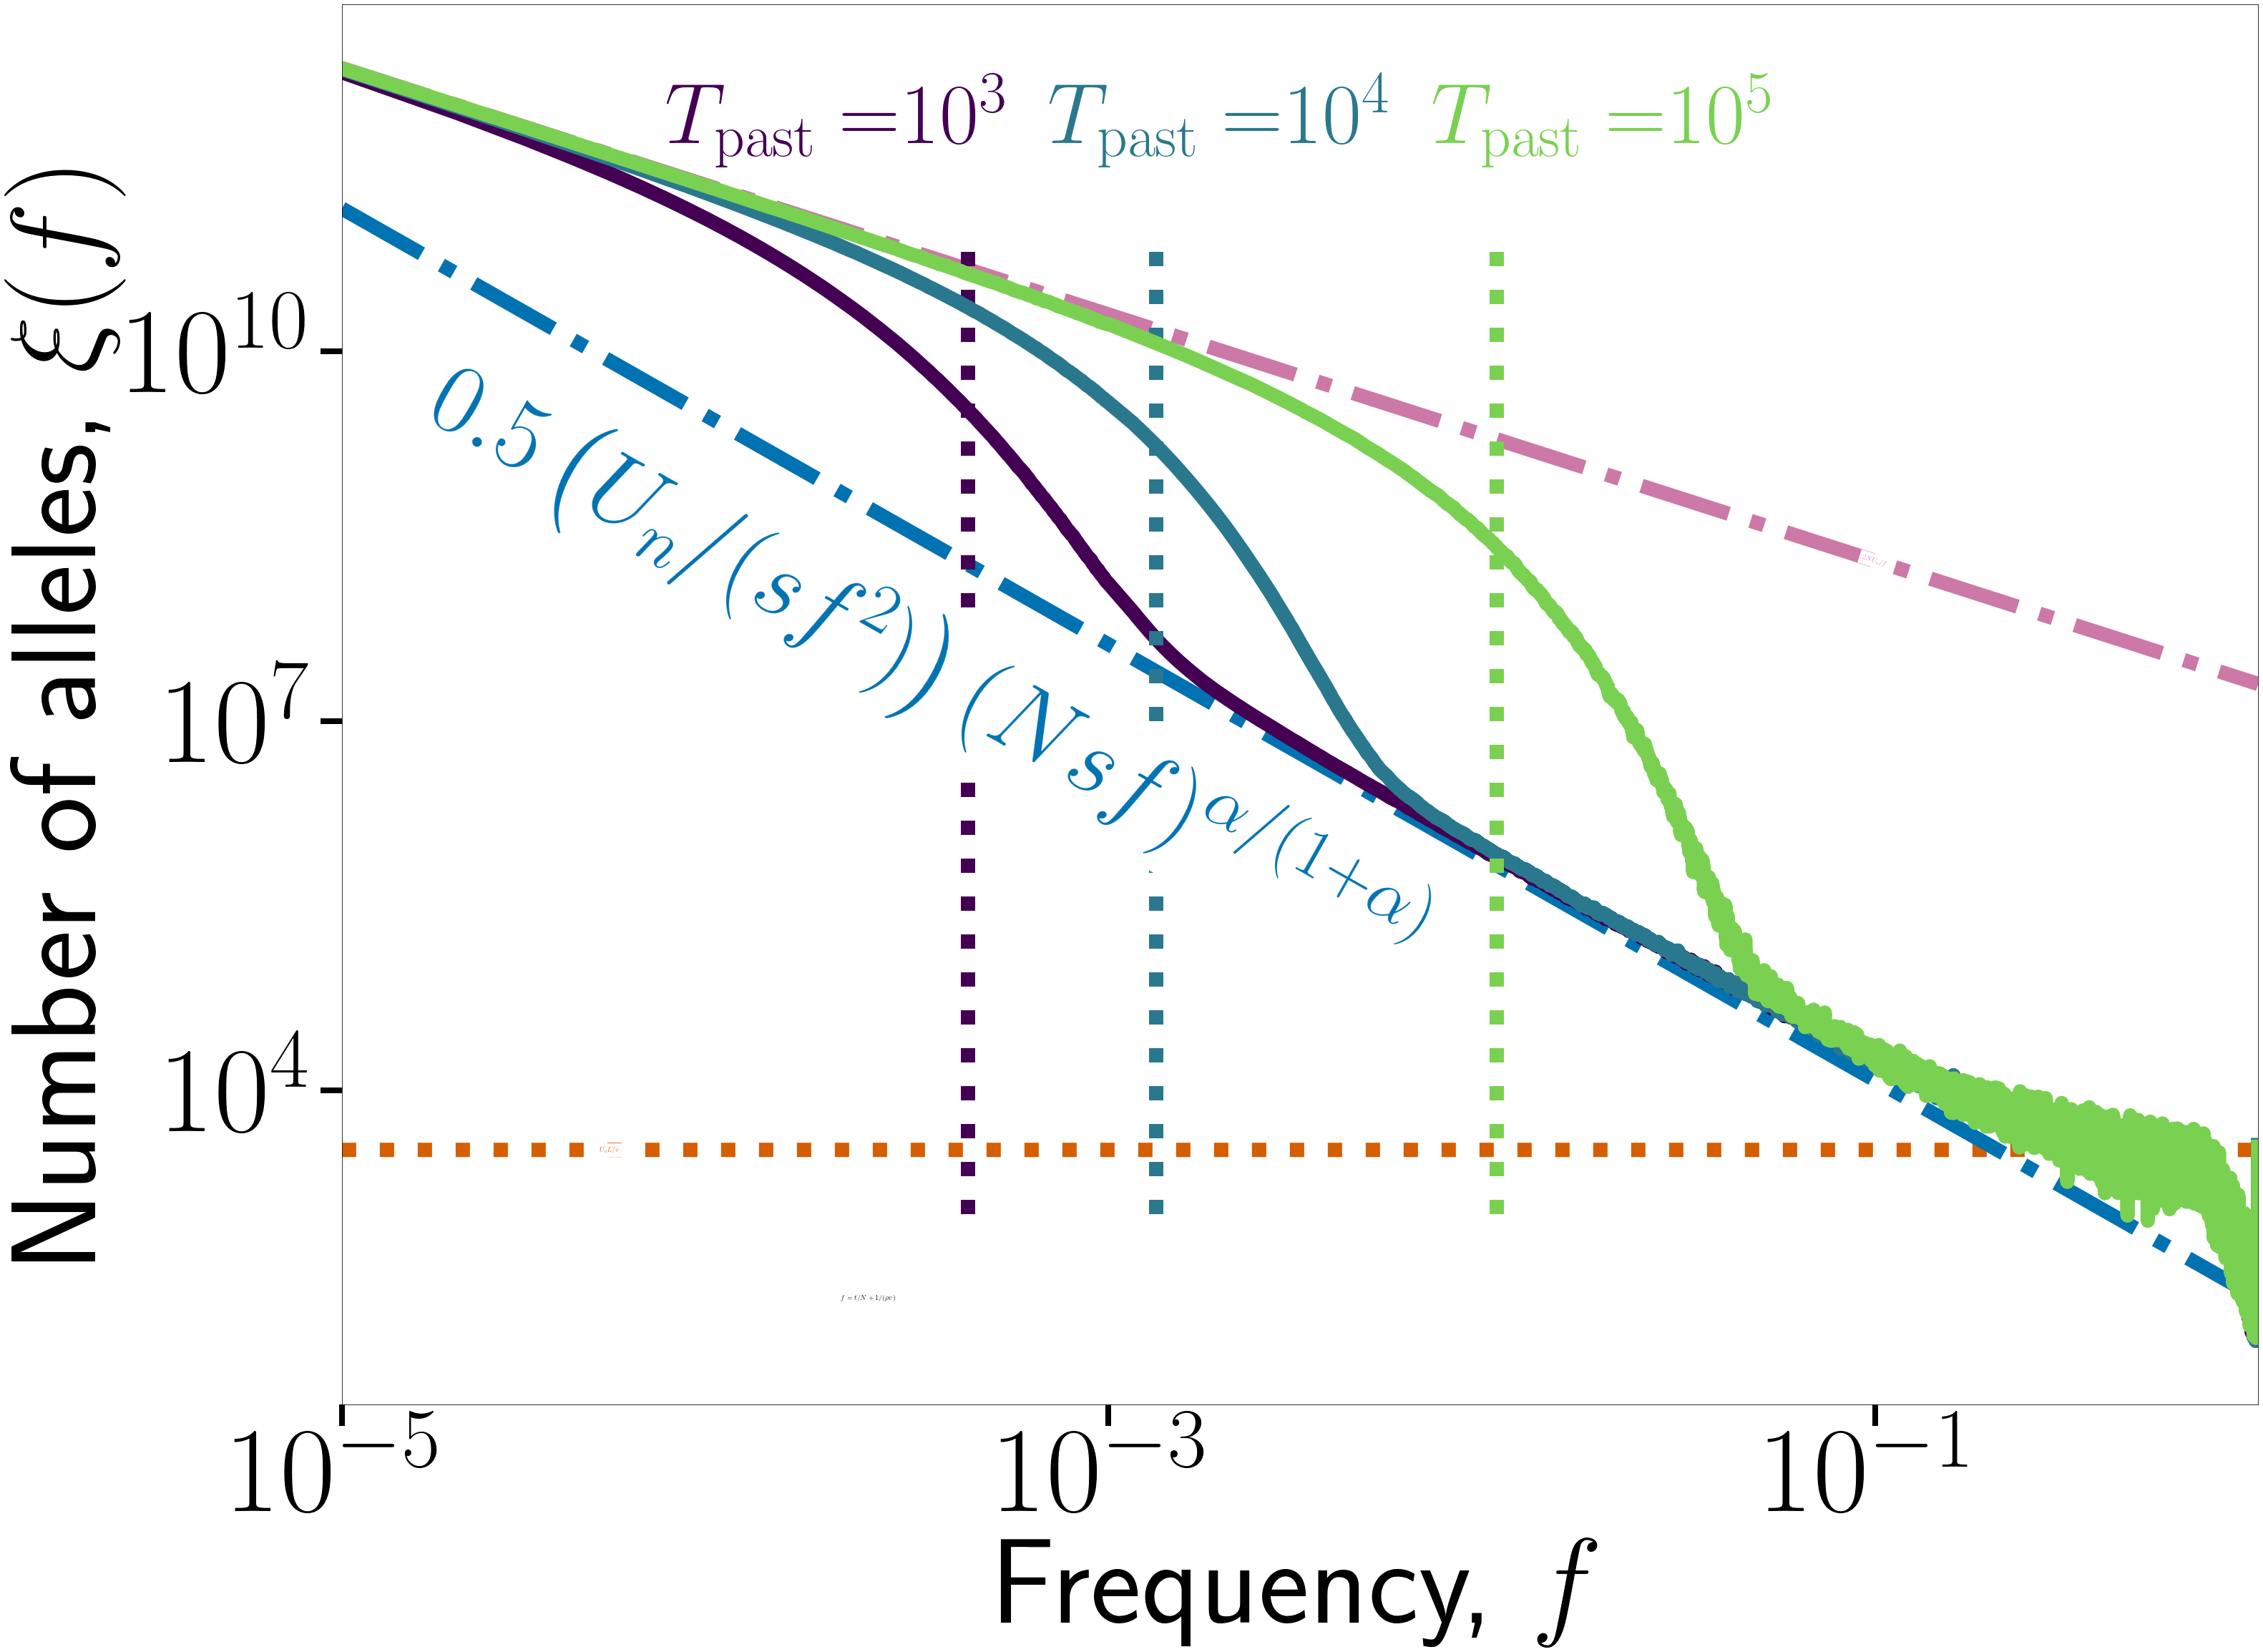

In [19]:
fig, ax = plt.subplots(figsize = (48, 36));
ax.set_xlabel(r'Frequency, $f$')
ax.set_ylabel(r'Number of alleles, $\xi(f)$')

L = 500
rho = 20000
N = L * rho
s = 0.05
m = 0.25
tfinal = 1000000
Un = 1
r = 0
n_forward = 100
tfix = 0

alpha = 0.3

n = 100000
nSFS = 1000

tfixlist = [1000, 10000, 100000]
viridis_cmap = cm.get_cmap('viridis')



f = np.arange(1, n + 1) / n
navg = 30
start_smooth = 100
f_short = moving_average(f, navg, start_smooth)

fit_range_ind = np.arange(200,1000)


freq_file = open(
   'forward_simulation_data/L={}_N={}_s={:.6f}_m={:.6f}_tfinal={}_0.txt'.format(
           L, rho, s, m, tfinal))
lines = np.loadtxt(freq_file, dtype=np.int64)
tf_real = len(lines)
v_list = []
for t in np.arange(int(tf_real / 4), int(tf_real * 3 / 4)):
    line1 = lines[t]
    line2 = lines[t + 1]
    psum1 = sum(line1) / rho
    psum2 = sum(line2) / rho
    v_list.append(psum2 - psum1)

v = np.average(v_list)
xpositions = [7 * 10 ** (-5), 7 * 10 ** (-4), 7 * 10 ** (-3)]

ax.text(2 * 10 ** -4, 200, r'$f = t / N + 1 / (\rho v)$')
flat, = ax.loglog(f_short, np.ones(len(f_short)) * L / v, 
           linestyle = 'dotted'
              , label = r'$ U_n L / v$', color = '#d55e00')
neutral, = ax.loglog(f_short, 
           2 * Un * N * np.ones(len(f_short)) / f_short,
           label = r'$2 N U_n / f$', linestyle = '-.',
           color = '#cc79a7')
bsc, = ax.loglog(f_short, 
           0.5 * Un / (s * f_short ** 2) * (N * s * f_short) ** (alpha / (1 + alpha)), 
           # label = r'$U_n \ln(Nsf)^3 \sqrt{m/s} / (L s f^2)$', 
           linestyle = '-.', color = '#0072b2')
ax.text(1.5e-5, 1e5, r'$0.5 \left(U_n / (s f^2)\right) (Nsf)^{\alpha / ( 1+\alpha)} $', 
        color = '#0072b2', fontsize=140, rotation=-29.5, backgroundcolor = 'w')

xvals = [5 * 10 ** (-5), 0.1, 0.5 * 10 ** (-4)]
labelLines(plt.gca().get_lines(), xvals = xvals, backgroundcolor = 'w',)

for tind in range(len(tfixlist)):
    tfix = tfixlist[tind]
    # Find v from lines
    SFS = np.loadtxt(
        'backward_simulation_data/SFS_L={}_N={}_s={:.6f}_m={:.6f}_r={:.6f}_tfinal={}_nsample={}_tfix={}_sample_uniform_navg={}_avged.txt'.format(L, 
                 rho, s, m, r, tfinal, n, tfix, nSFS))

    ax.loglog(f_short, 
                 moving_average(SFS, navg, start_smooth), 
                 color = viridis_cmap(tind * 0.4), 
                 label = '$t =$' + sci_notation(tfix))
    
    ax.vlines(tfix / N + 1 / (v * rho), 10 ** 3, 10 ** 11, linestyle = 'dotted',
               color = viridis_cmap(tind * 0.4))
    ax.text(xpositions[tind], 5 * 10 ** 11, 
             r'$T_\mathrm{past} = $' + r'$10^{}$'.format(tind + 3), 
             color = viridis_cmap(tind * 0.4), fontsize = 120)    


ax.set_xlim((1e-5, 1))


In [88]:
# save figure:
fig.savefig('uniform_tail.pdf', format = 'pdf', bbox_inches = 'tight')

(1e-05, 1.0)

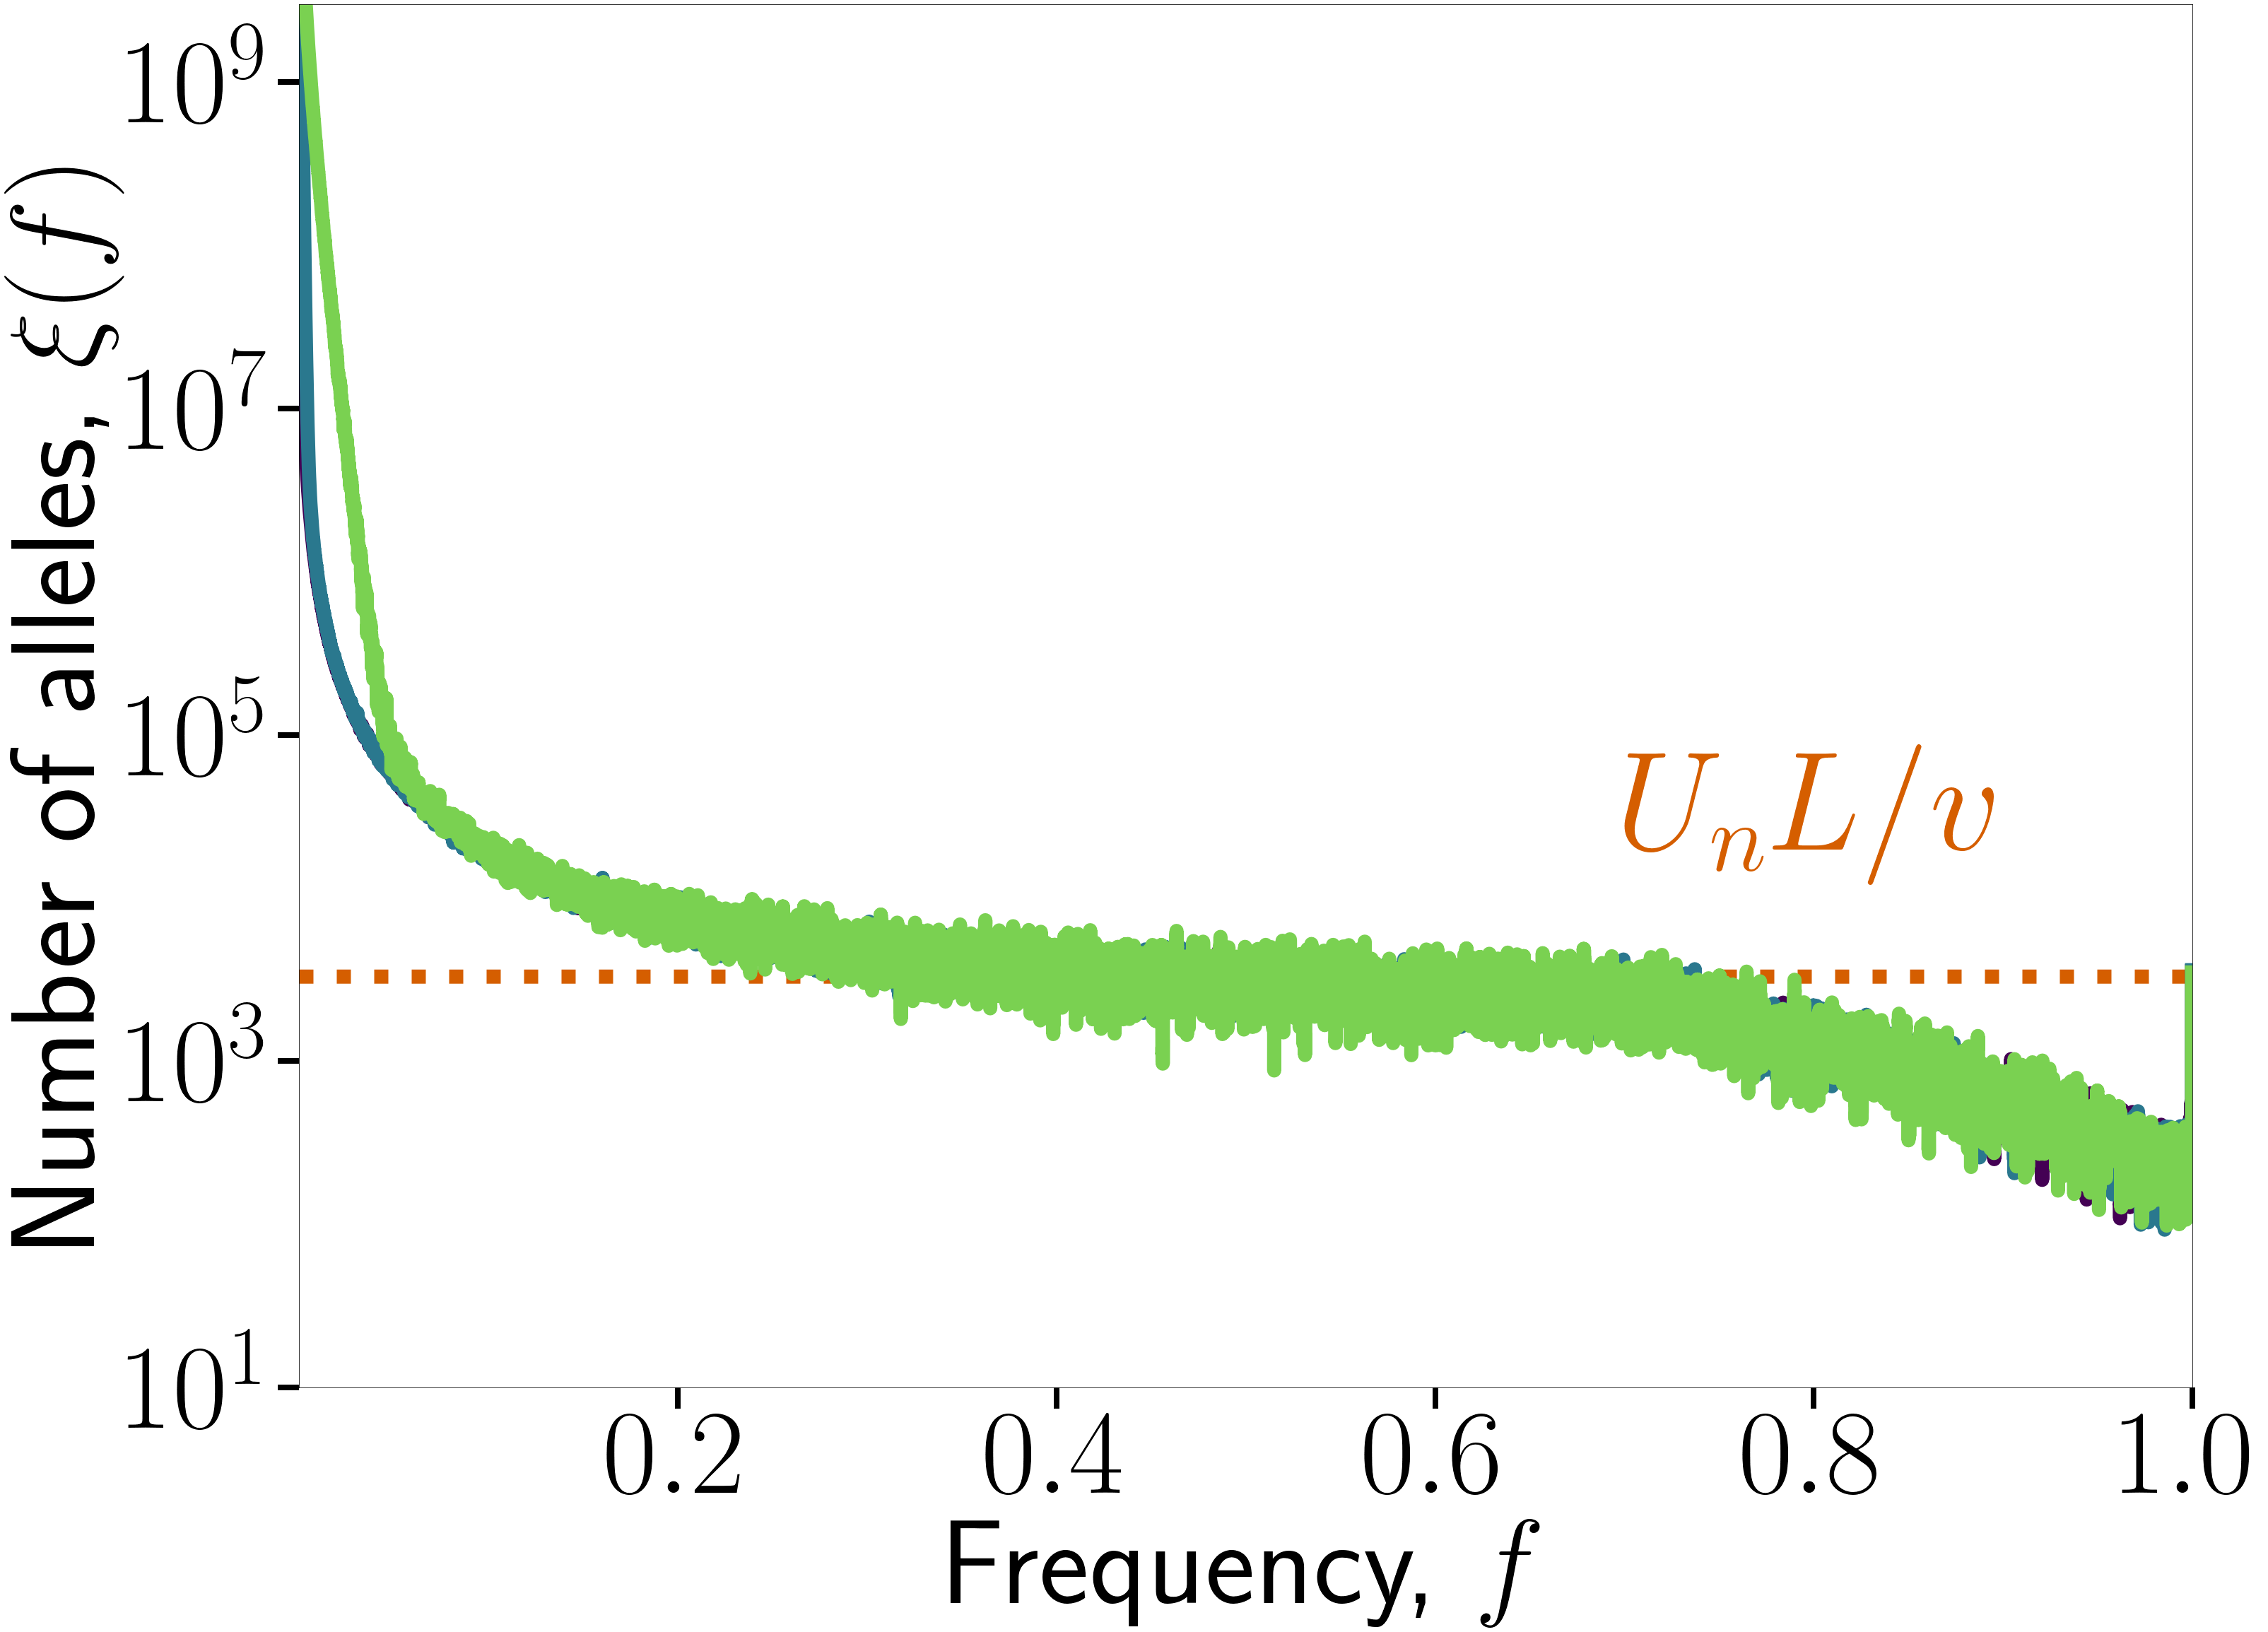

In [34]:
fig, ax = plt.subplots(figsize = (48, 36));
ax.set_xlabel(r'Frequency, $f$')
ax.set_ylabel(r'Number of alleles, $\xi(f)$')
ax.semilogy(f_short, np.ones(len(f_short)) * L / v, 
           linestyle = 'dotted'
              , label = r'$ U_n L / v$', color = '#d55e00')
ax.text(0.7, 2e4, r'$U_n L / v$', 
        color = '#d55e00', fontsize=200, backgroundcolor = 'w')
for tind in range(len(tfixlist)):
    tfix = tfixlist[tind]
    # Find v from lines
    SFS = np.loadtxt(
        'backward_simulation_data/SFS_L={}_N={}_s={:.6f}_m={:.6f}_r={:.6f}_tfinal={}_nsample={}_tfix={}_sample_uniform_navg={}_avged.txt'.format(L, 
                 rho, s, m, r, tfinal, n, tfix, nSFS))

    ax.semilogy(f_short, 
                 moving_average(SFS, navg, start_smooth), 
                 color = viridis_cmap(tind * 0.4), 
                 label = '$t =$' + sci_notation(tfix))

ax.set_ylim((1e1, 3e9))
ax.set_xlim((1e-5, 1))

In [35]:
# save figure:
fig.savefig('uniform_tail_linear.pdf', format = 'pdf', bbox_inches = 'tight')

## SFS of sexual population (compare 1D and well-mixed with the same $r, s$)

In [36]:
rho = 5000
L = 2000
N = rho * L
m = 0.25
Un = 1

n_forward = 100
T_after_fix = 0
tfinal = 100000

s = 0.05
n = 10000
n_sim_well_mixed = 10000


In [37]:
def logit(x):
    return np.log(x / (1 - x))

In [38]:

freq_file = open(
       'forward_simulation_data/L={}_N={}_s={:.6f}_m={:.6f}_tfinal={}_0.txt'.format(L, rho, s, m, tfinal))
lines = np.loadtxt(freq_file, dtype=np.int64)
tf_real = len(lines)
v_list = []
for t in np.arange(int(tf_real / 4), int(tf_real * 3 / 4)):
    line1 = lines[t]
    line2 = lines[t + 1]
    psum1 = sum(line1) / rho
    psum2 = sum(line2) / rho
    v_list.append(psum2 - psum1)
    
v = np.average(v_list)


In [39]:
#1) large r where neutral diversity is recovered for both well-mixed and 1D

r = 0.01
nback_sim_1d = 1000

# Load the SFSs
SFS_1d = np.loadtxt('backward_simulation_data/expected_SFS_L=' 
    + '{}_N={}_s={:.3f}_m={:.2f}_r={:.2e}_nsample={}_t_after_fix={}_Nback={}_avged.txt'.format(L, 
             rho, s, m, r, n, T_after_fix, nback_sim_1d))

SFS_well_mixed = np.loadtxt(
            'backward_simulation_data/'
            + 'expected_SFS_well_mixed_N={}_Tfix={}_s={:.2f}_r={:.2e}_nsample={}_nsim={}.txt'.format(
                    N, T_after_fix, s, r, n, n_sim_well_mixed))



In [40]:

smooth_start_1d = 70
window_size_1d = 100
smooth_start_wellmixed = 70
window_size_wellmixed = 100

f = np.arange(1 / n, 1 + 1 / n, 1 / n)
f_short_1d = moving_average(f, window_size_1d, smooth_start_1d)
f_short_wellmixed = moving_average(f, window_size_wellmixed, smooth_start_wellmixed)


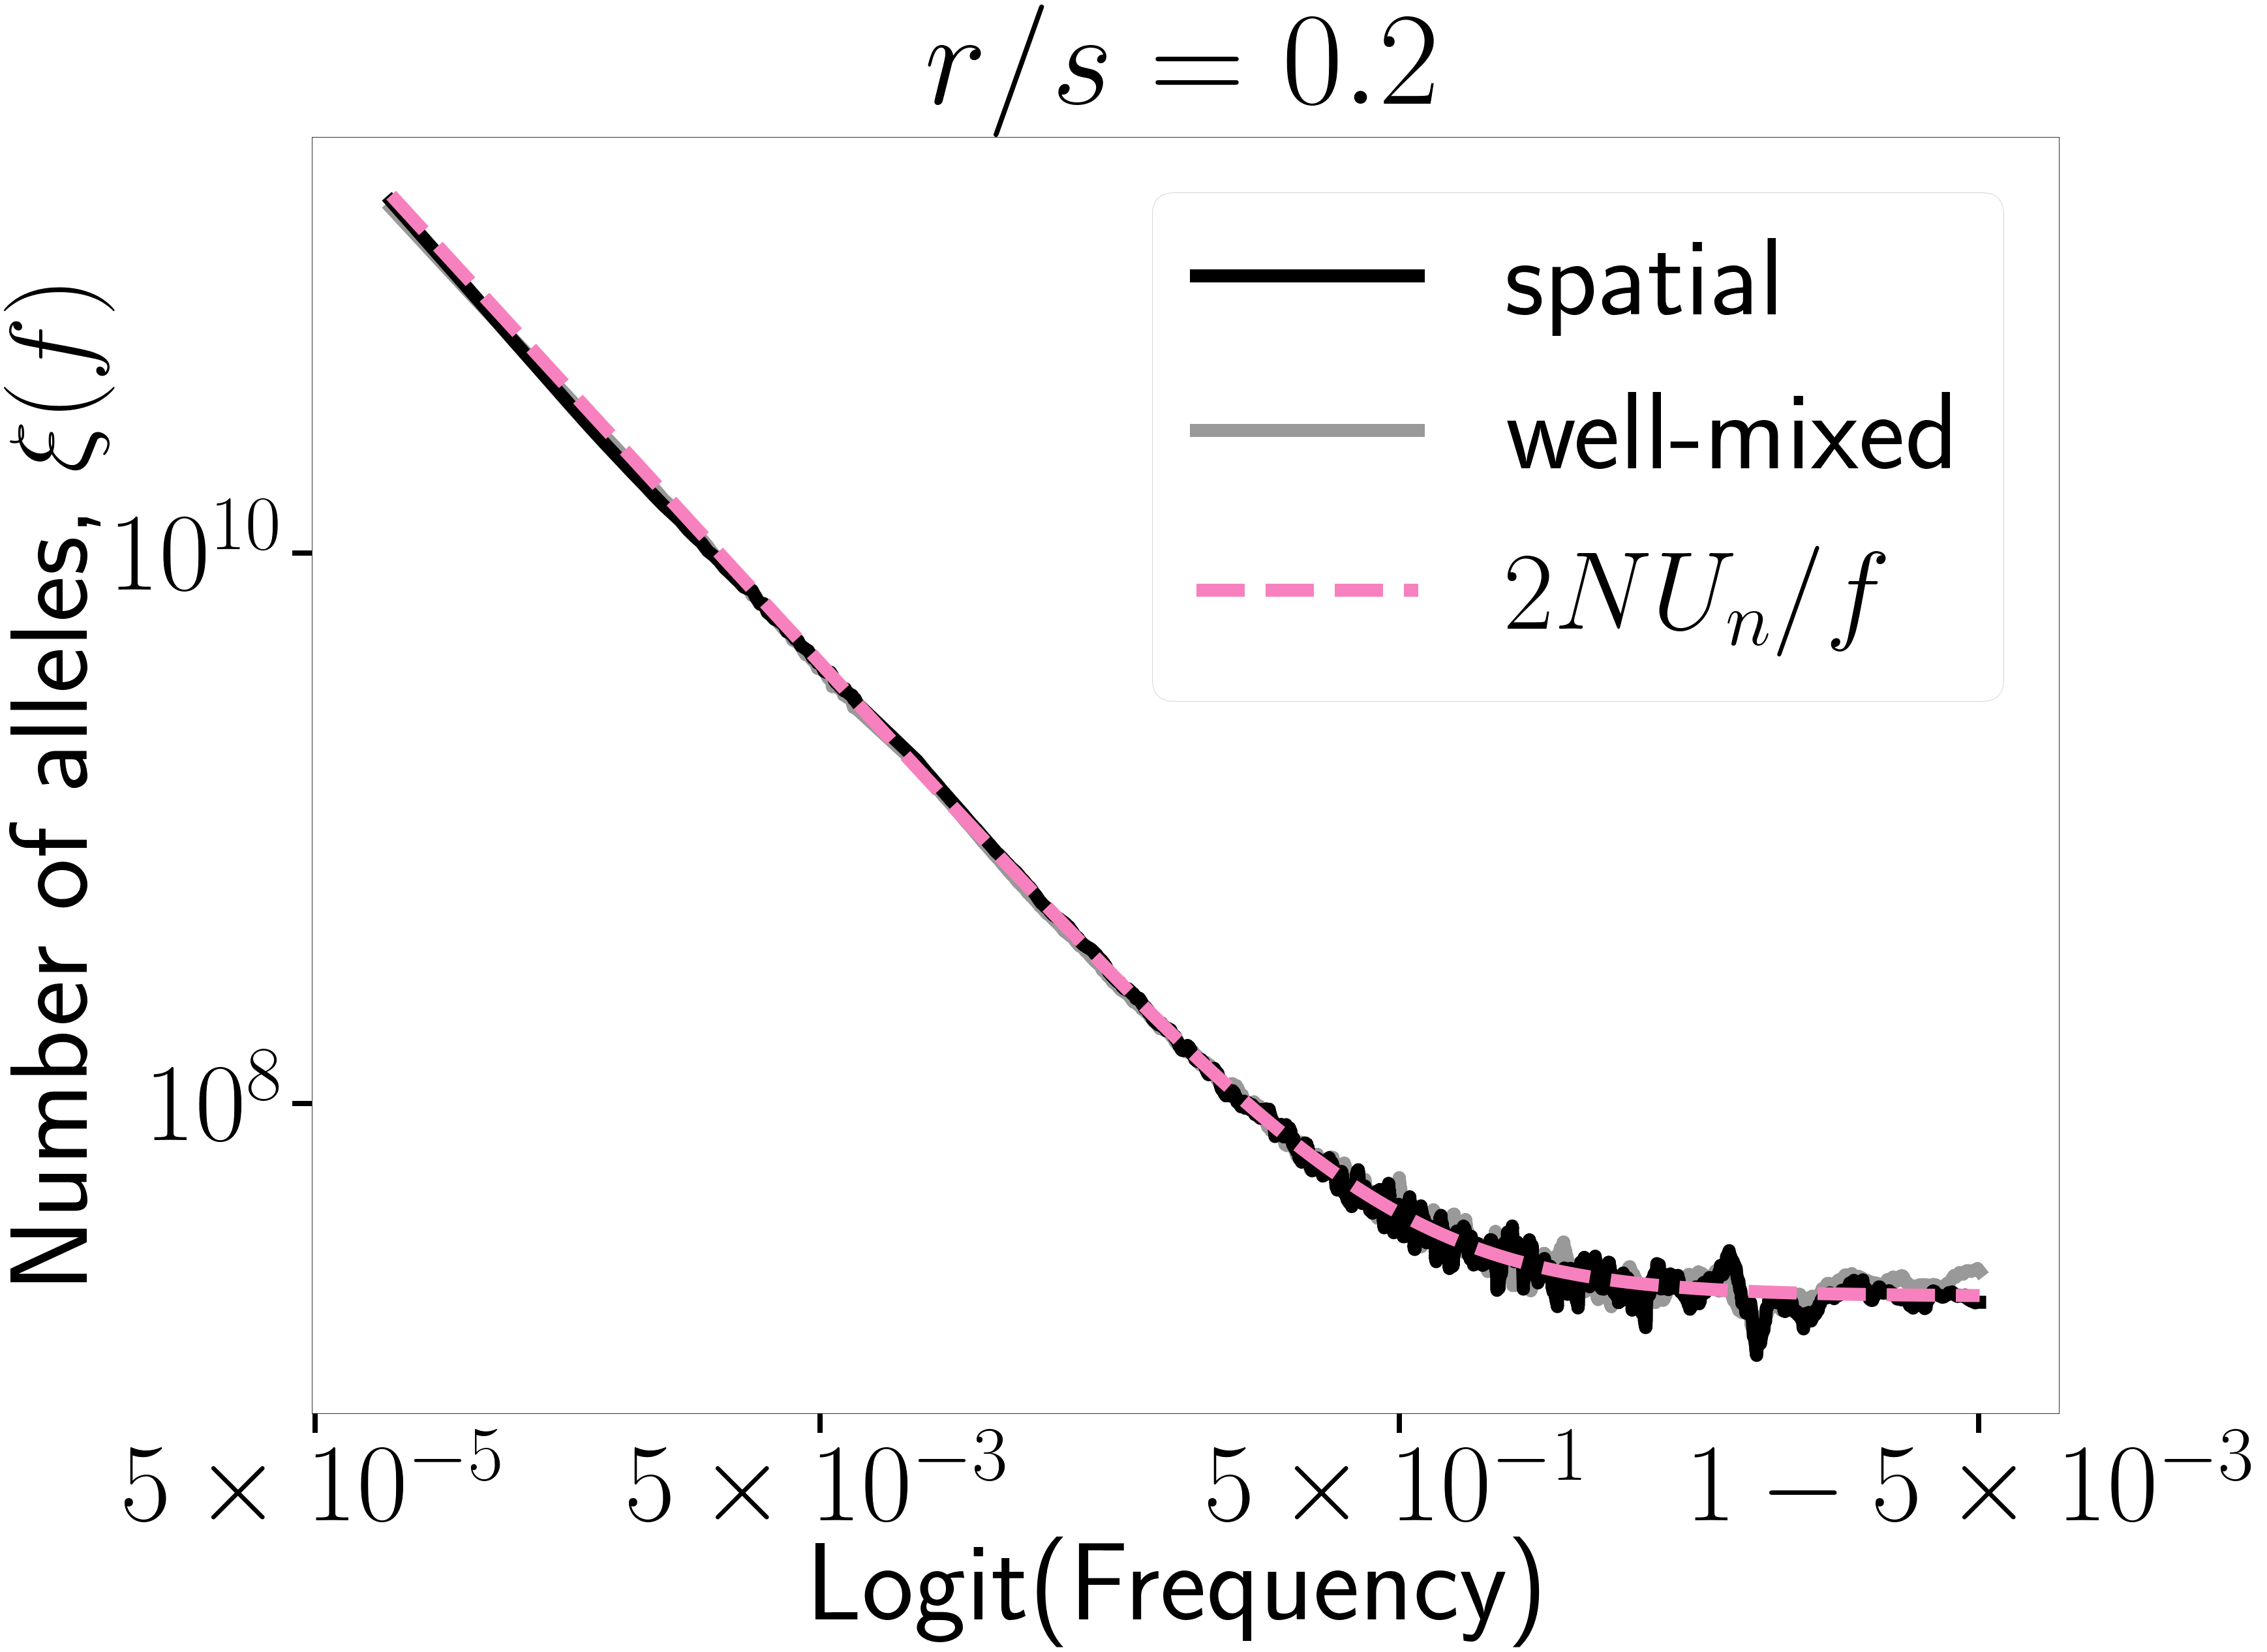

In [48]:
# Plot SFSs (1D and well-mixed) and neutral asymptote

fig, ax = plt.subplots(figsize = (48, 36));
ax.set_xlabel('Logit(Frequency)')
ax.set_ylabel(r'Number of alleles, $\xi(f)$')
ax.set_title(r'$r / s = {:.1f}$'.format(r / s))


ax.semilogy(logit(f_short_1d), moving_average(SFS_1d, 
                  window_size_1d, smooth_start_1d), 
        label = 'spatial'.format(r), color = 'k')
ax.semilogy(logit(f_short_wellmixed), moving_average(SFS_well_mixed,
                 window_size_1d, smooth_start_1d), 
            alpha = 0.4, color = 'k', label = 'well-mixed')
ax.semilogy(logit(f_short_1d), 2 * Un * N / f_short_1d, 
                 linestyle = '--', label = r'$2 N U_n / f$', 
                 color = '#f781bf')
plt.xticks([logit(0.5 / 10 ** i) for i in np.arange(0, 5, 2)] 
           + [logit(1 - 0.5 / 10 ** i) for i in np.arange(2, 3, 2)], 
           [r'$5 \times 10^{{{}}}$'.format(- (i + 1)) for i in np.arange(0, 5, 2)]
          + [r'$1 - 5 \times 10^{{{}}}$'.format(- (i + 1)) for i in np.arange(2, 3, 2)])

ax.legend()

In [99]:
fig.savefig('sex_high.pdf', format = 'pdf', bbox_inches = 'tight')

In [49]:
# 2) v / L << r << lambda << s

r = 5 * 10 ** -4
nback_sim_1d = 1000

# Import the SFSs
SFS_1d = np.loadtxt('backward_simulation_data/expected_SFS_L=' 
    + '{}_N={}_s={:.3f}_m={:.2f}_r={:.2e}_nsample={}_t_after_fix={}_Nback={}_avged.txt'.format(L, 
             rho, s, m, r, n, T_after_fix, nback_sim_1d))

SFS_well_mixed = np.loadtxt(
            'backward_simulation_data/'
            + 'expected_SFS_well_mixed_N={}_Tfix={}_s={:.2f}_r={:.2e}_nsample={}_nsim={}.txt'.format(
                    N, T_after_fix, s, r, n, n_sim_well_mixed))



In [50]:

smooth_start_1d = 70
window_size_1d = 100
smooth_start_wellmixed = 70
window_size_wellmixed = 100

f = np.arange(1 / n, 1 + 1 / n, 1 / n)
f_short_1d = moving_average(f, window_size_1d, smooth_start_1d)
f_short_wellmixed = moving_average(f, window_size_wellmixed, smooth_start_wellmixed)
SFS_1d_smooth = moving_average(SFS_1d, window_size_1d, smooth_start_1d)



f_BSC_left = np.linspace(10 ** -2.8, 10 ** -1.2)
f_BSC_right = np.linspace(0.9, 0.995)
f_uniform = np.linspace(10 ** -1, 0.9)
f_BSC_left_wellmixed = np.linspace(np.log(N * s) * r / s, 0.5)
f_BSC_right_wellmixed = np.linspace(0.5, 1 - np.log(N * s) * r / s)


In [51]:
def deviate_from_neutral(SFS_1d, SFS_neutral, f, df):
    '''return how much SFS_1d deviates from neutral SFS in [f - df, f + df] window.'''
    delta_SFS_normalized = np.divide(SFS_1d[int((f - df) * n):int((f + df) * n)] - SFS_neutral[int((f - df) * n):int((f + df) * n)]
                           , SFS_neutral[int((f - df) * n):int((f + df) * n)])
    
    rms = np.sqrt(np.mean(delta_SFS_normalized ** 2))
    return rms

In [52]:
# Put arrows where the 1D SFS starts converging to neutral expected pattern. (start and end f)

f_arrow_start = 0.5
df = 5 / n
error_start = deviate_from_neutral(SFS_1d_smooth, 2 * N * Un / f_short_1d, f_arrow_start, df)

error_threshold = 0.5
while error_start < error_threshold:
    f_arrow_start -= df
    error_start = deviate_from_neutral(SFS_1d_smooth, 2 * N * Un / f_short_1d, f_arrow_start, df)

if f_arrow_start < df:
    f_arrow_start = 1 / n
f_arrow_end = 0.5
error_end = deviate_from_neutral(SFS_1d_smooth, 2 * N * Un / f_short_1d, f_arrow_end, df)

while error_end < error_threshold:
    f_arrow_end += df
    error_end = deviate_from_neutral(SFS_1d_smooth, 2 * N * Un / f_short_1d, f_arrow_end, df)
if f_arrow_end > 1 - df:
    f_arrow_end = 1 - 1 / n



([<matplotlib.axis.XTick at 0x21720f1f6a0>,
 [Text(0.0, 0, '$5 \\times 10^{-1}$'),
  Text(-5.293304824724492, 0, '$5 \\times 10^{-3}$'),
  Text(-9.903437551286085, 0, '$5 \\times 10^{-5}$'),
  Text(5.293304824724491, 0, '$1 - 5 \\times 10^{-3}$')])

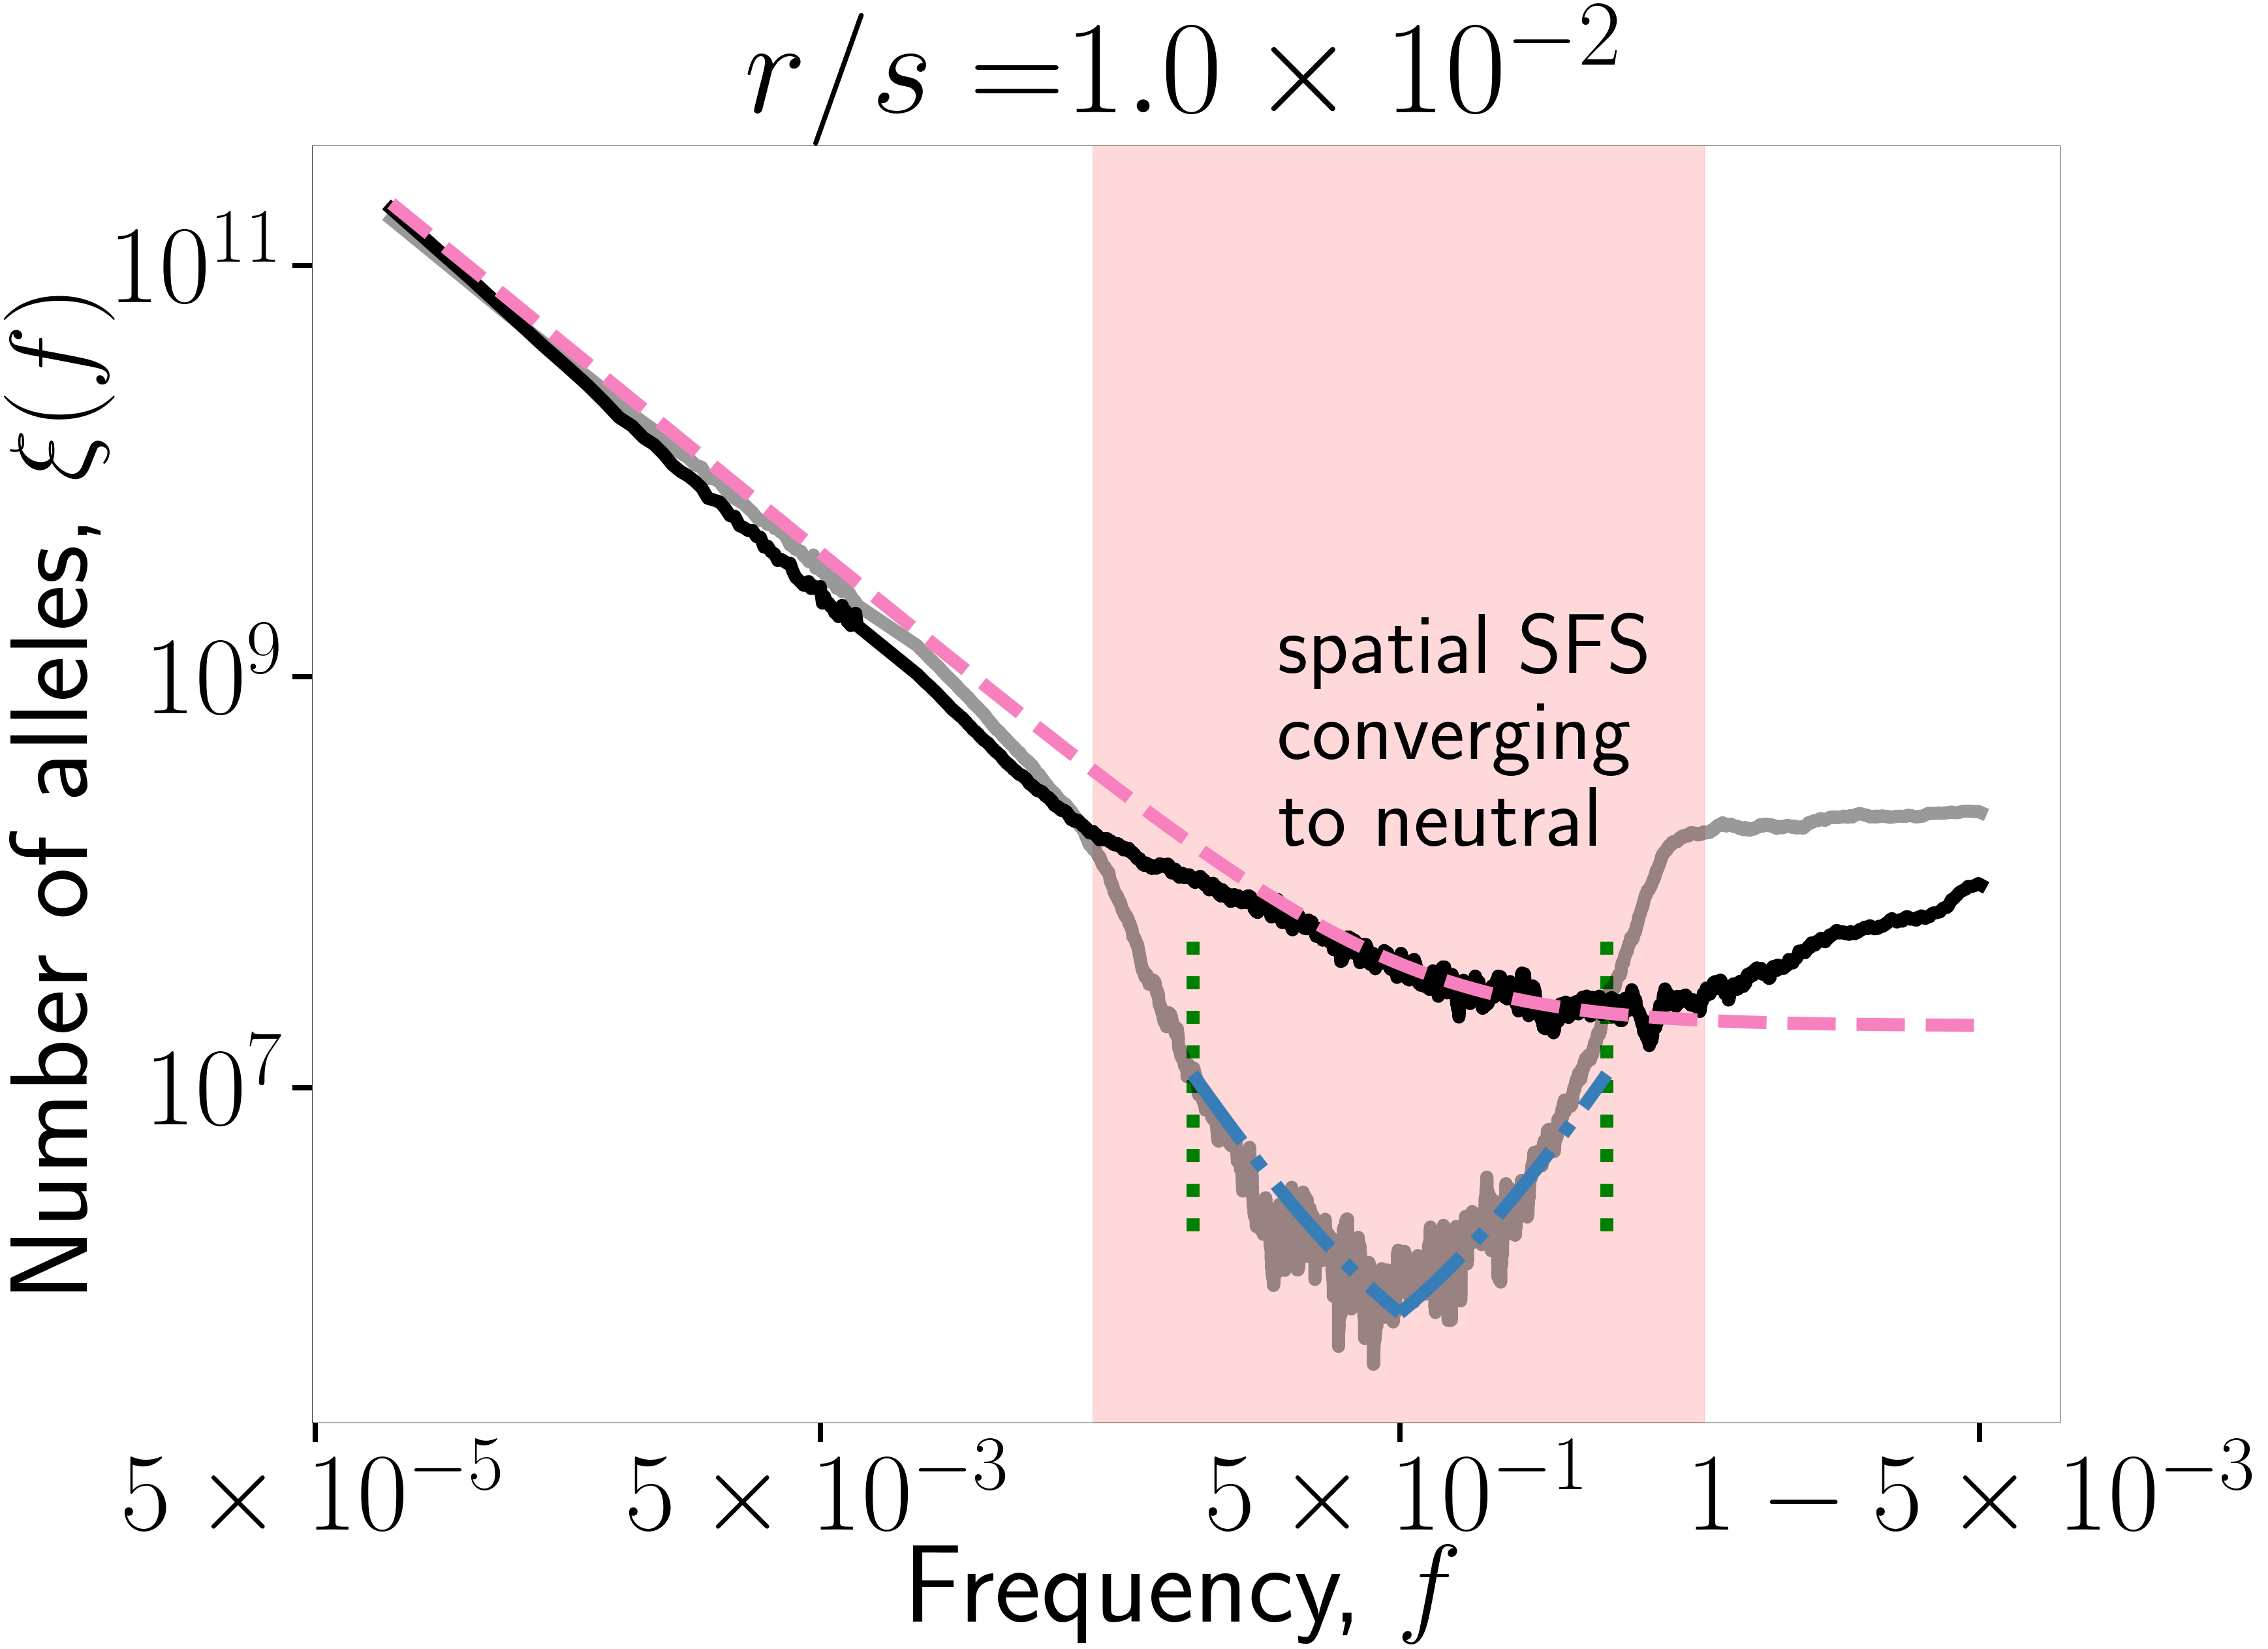

In [53]:
# Plot SFSs (1D and well-mixed), neutral asymptote, and non-neutral asymptotes

fig, ax = plt.subplots(figsize = (48, 36));
ax.set_xlabel(r'Frequency, $f$')
ax.set_ylabel(r'Number of alleles, $\xi(f)$')
ax.set_title(r'$r / s = $' + sci_notation(r / s, exponent = -2))

ax.semilogy(logit(f_short_1d), SFS_1d_smooth, color = 'k')
ax.semilogy(logit(f_short_wellmixed), moving_average(SFS_well_mixed,
                 window_size_wellmixed, smooth_start_wellmixed), 
            alpha = 0.4, color = 'k')
ax.semilogy(logit(f_short_1d), 2 * N / f_short_1d, 
                 linestyle = '--', 
                 color = '#f781bf')

ax.semilogy(logit(f_BSC_left_wellmixed), 
                  (1 + 2 * N * r) / s / f_BSC_left_wellmixed ** 2, 
                  linestyle = '-.', 
                  label = r'$U_\mathrm{n, eff} / s f^2$', 
                  color = '#377eb8')

ax.semilogy(logit(f_BSC_right_wellmixed), 
                  (2 * N * r) / s / (1 - f_BSC_right_wellmixed) ** 2, 
                  linestyle = '-.',  
                  color ='#377eb8', 
                  label = r'$(U_\mathrm{n, eff} - U_n) N r / s (1 - f)^2$')
ax.text(-1.1, 1.5 * 10 ** 8, 'spatial SFS \n converging \n to neutral', fontsize = 130)

ax.axvspan(logit(f_arrow_start), logit(f_arrow_end), alpha = 0.15, color = 'r')

ax.vlines(logit(np.log(N * s) * r / s), 2 * 10 ** 6, 6 * 10 ** 7, linestyle = 'dotted', color = 'g')
ax.vlines(-logit(np.log(N * s) * r / s), 2 * 10 ** 6, 6 * 10 ** 7, linestyle = 'dotted', color = 'g')
plt.xticks([logit(0.5 / 10 ** i) for i in np.arange(0, 5, 2)] 
           + [logit(1 - 0.5 / 10 ** i) for i in np.arange(2, 3, 2)], 
           [r'$5 \times 10^{{{}}}$'.format(- (i + 1)) for i in np.arange(0, 5, 2)]
          + [r'$1 - 5 \times 10^{{{}}}$'.format(- (i + 1)) for i in np.arange(2, 3, 2)])


#ax.legend(fontsize = 80, loc = 'lower left')

In [54]:
fig.savefig('sex_middle.pdf', format = 'pdf', bbox_inches = 'tight')

In [55]:
# 3)  r << v / L << lambda << s

r = 10 ** -4
nback_sim_1d = 1000

# Import the SFSs
SFS_1d = np.loadtxt('backward_simulation_data/expected_SFS_L=' 
    + '{}_N={}_s={:.3f}_m={:.2f}_r={:.2e}_nsample={}_t_after_fix={}_Nback={}_avged.txt'.format(L, 
             rho, s, m, r, n, T_after_fix, nback_sim_1d))

SFS_well_mixed = np.loadtxt(
            'backward_simulation_data/'
            + 'expected_SFS_well_mixed_N={}_Tfix={}_s={:.2f}_r={:.2e}_nsample={}_nsim={}.txt'.format(
                    N, T_after_fix, s, r, n, n_sim_well_mixed))



In [56]:

smooth_start_1d = 70
window_size_1d = 100
smooth_start_wellmixed = 150
window_size_wellmixed = 200

f = np.arange(1 / n, 1 + 1 / n, 1 / n)
f_short_1d = moving_average(f, window_size_1d, smooth_start_1d)
f_short_wellmixed = moving_average(f, window_size_wellmixed, smooth_start_wellmixed)


f_BSC_left = np.linspace(10 ** -2.8, 10 ** -1.2)
f_BSC_right = np.linspace(0.9, 0.995)
f_uniform = np.linspace(10 ** -1, 0.9)
f_BSC_left_wellmixed = np.linspace(np.log(N * s) * r / s, 0.5)
f_BSC_right_wellmixed = np.linspace(0.5, 1 - np.log(N * s) * r / s)

([<matplotlib.axis.XTick at 0x21797ff21f0>,
 [Text(0.0, 0, '$5 \\times 10^{-1}$'),
  Text(-5.293304824724492, 0, '$5 \\times 10^{-3}$'),
  Text(-9.903437551286085, 0, '$5 \\times 10^{-5}$'),
  Text(5.293304824724491, 0, '$1 - 5 \\times 10^{-3}$')])

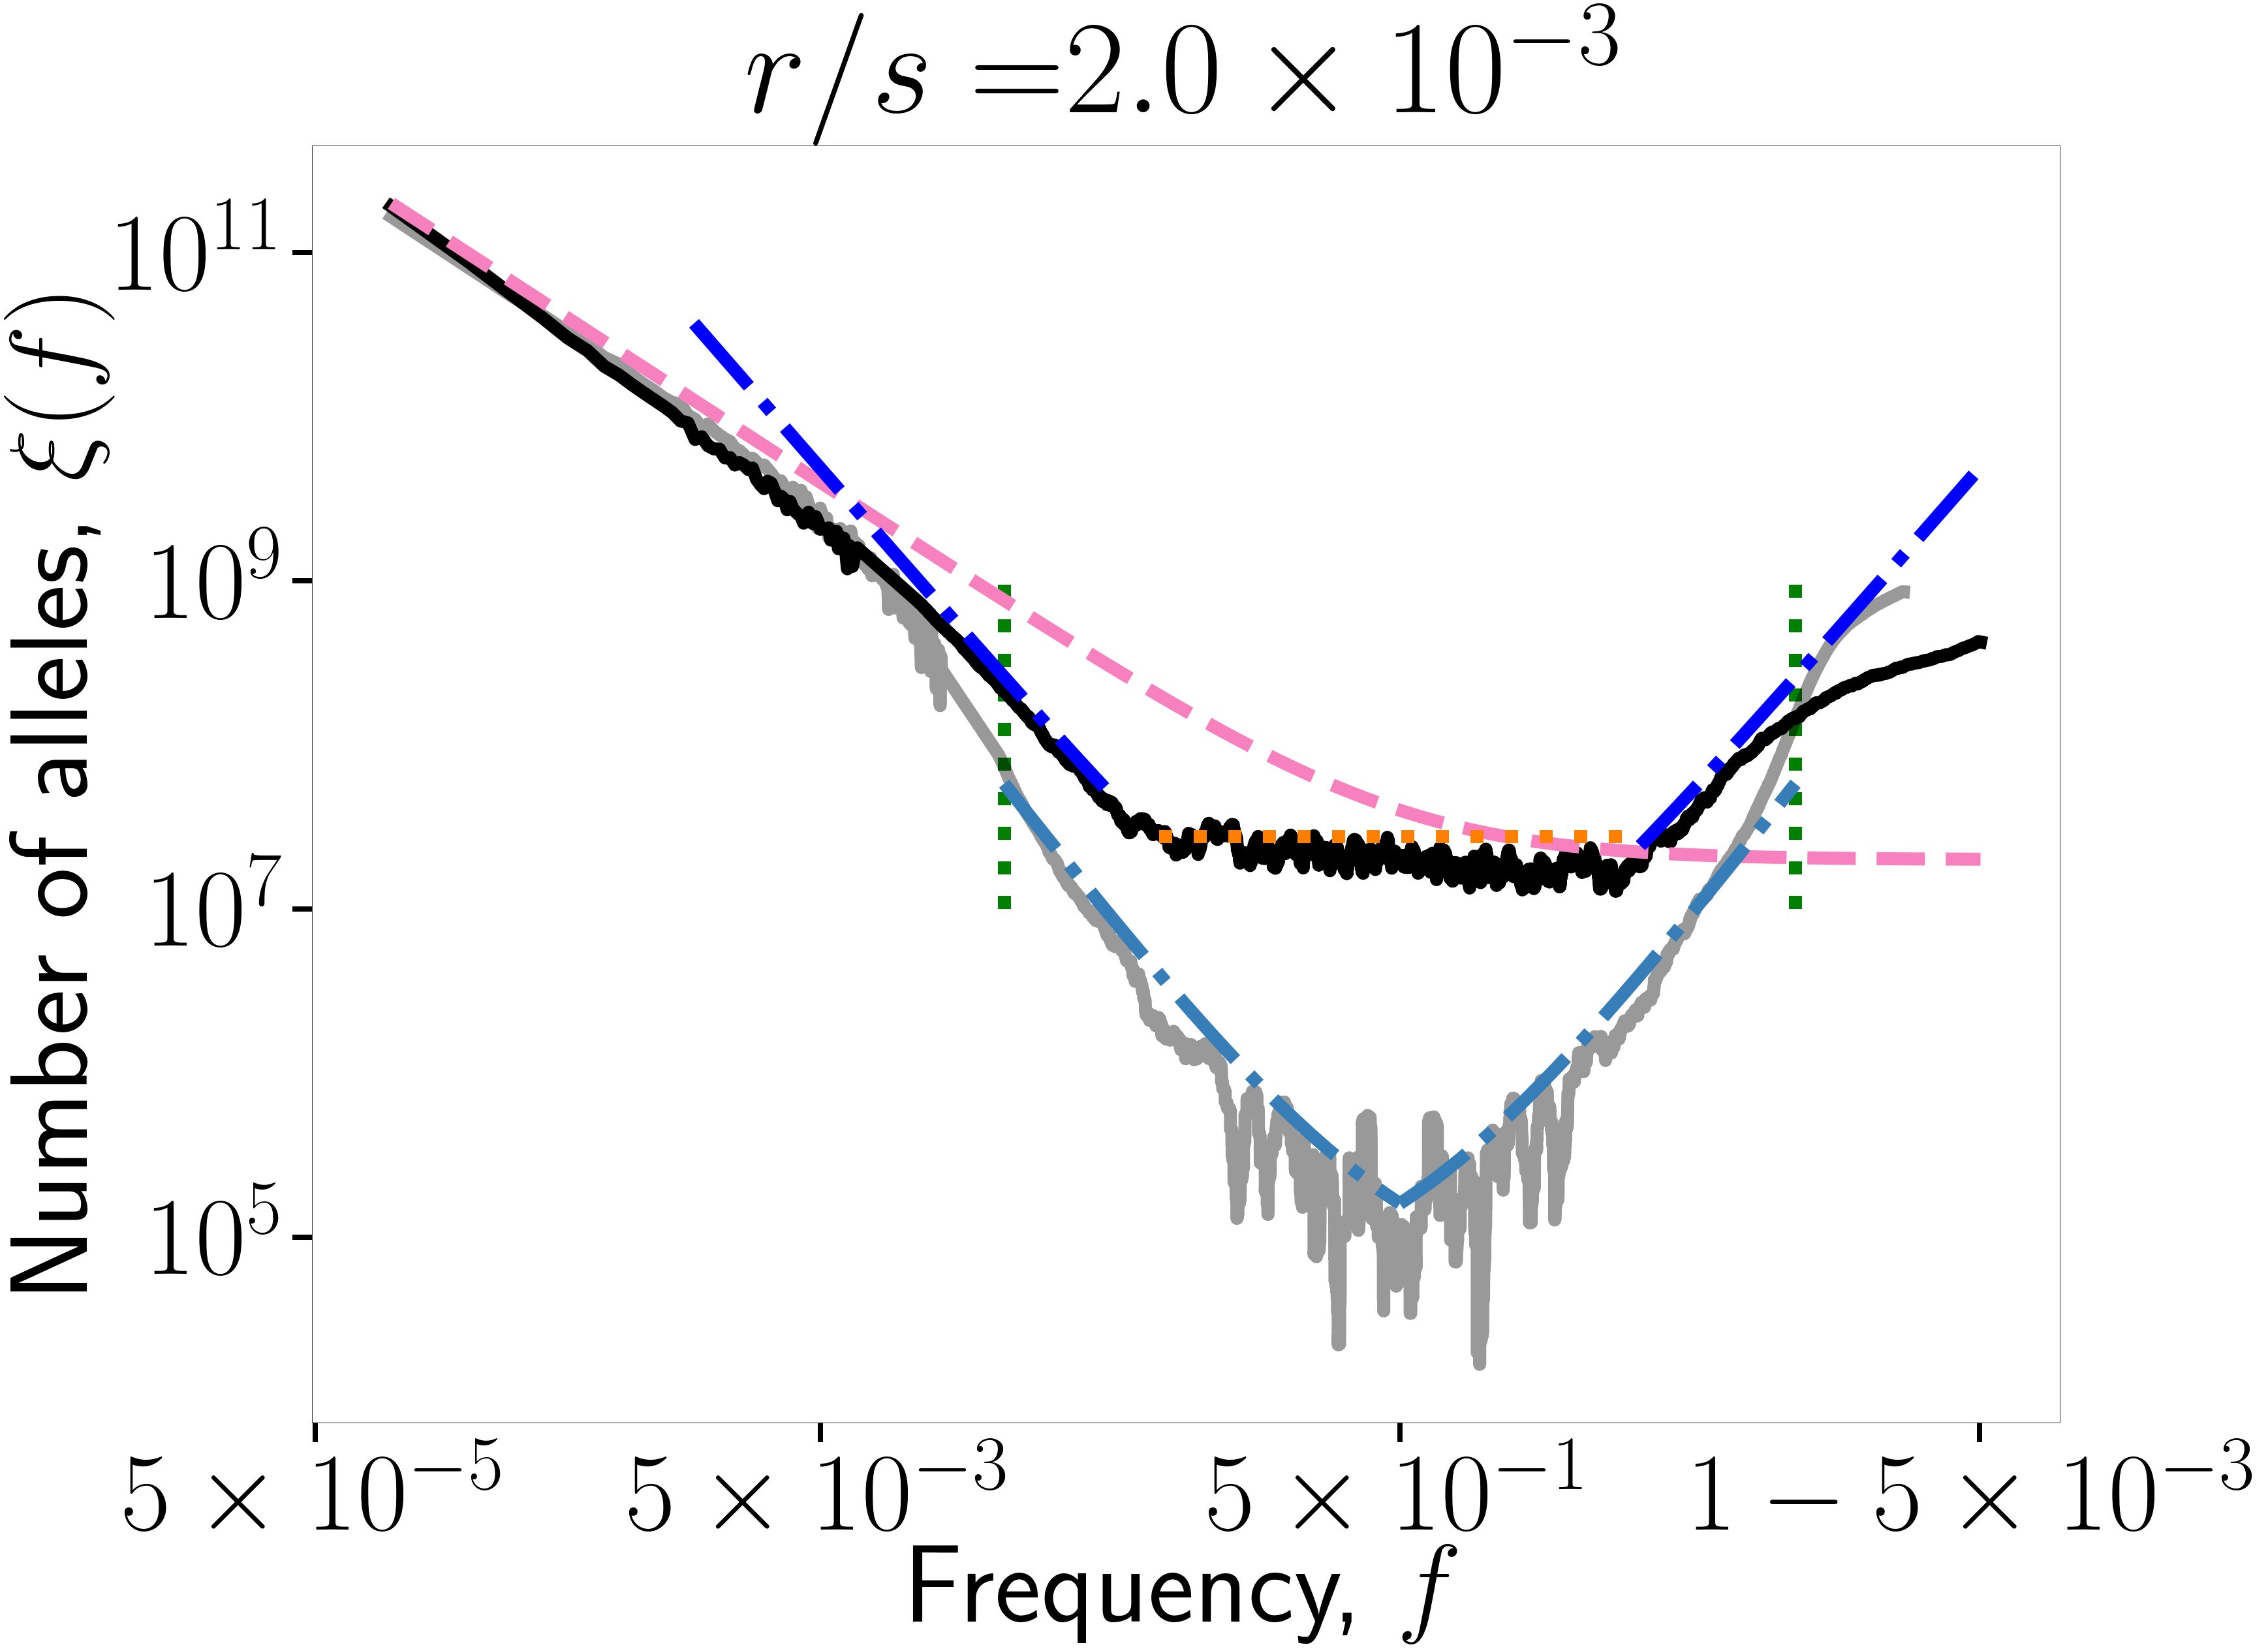

In [57]:
# Plot SFSs (1D and well-mixed), neutral asymptote, and non-neutral asymptotes
alpha = 0.3
fig, ax = plt.subplots(figsize = (48, 36));
ax.set_xlabel(r'Frequency, $f$')
ax.set_ylabel(r'Number of alleles, $\xi(f)$')
ax.set_title(r'$r / s = $' + sci_notation(r / s))

ax.semilogy(logit(f_short_1d), moving_average(SFS_1d, 
                  window_size_1d, smooth_start_1d), color = 'k')
ax.semilogy(logit(f_short_wellmixed), moving_average(SFS_well_mixed,
                 window_size_wellmixed, smooth_start_wellmixed), 
            alpha = 0.4, color = 'k')
ax.semilogy(logit(f_short_1d), 2 * N / f_short_1d, 
                 linestyle = '--', 
                 color = '#f781bf')

ax.semilogy(logit(f_uniform), 
                      (1 + 2 * N * r) * L / v * np.ones(len(f_uniform)), 
                  linestyle = 'dotted', 
                  label = r'$U_\mathrm{n, eff} L / v$', 
                  color = '#ff7f00')
ax.semilogy(logit(f_BSC_left), 
                  0.5 * (1 + 2 * N * r) * (N * s * f_BSC_left) ** (alpha / (1 + alpha)) / s / f_BSC_left ** 2, 
                  linestyle = '-.', 
                  label = r'$0.5 \left(U_\mathrm{n, eff} / (sf^2)\right) (Nsf)^{\alpha / (1 + \alpha)}$', 
                  color = 'b')

ax.semilogy(logit(f_BSC_right), 
                  0.5 * (2 * N * r) * (N * s * (1 - f_BSC_right)) ** (alpha / (1 + alpha)) / s / (1 - f_BSC_right) ** 2, 
                  linestyle = '-.', 
                  color ='b', 
                  label = r'$0.5 \left((U_\mathrm{n, eff} - U_n) / (s(1 - f)^2)\right) (Ns(1 - f))^{\alpha / (1 + \alpha)}$')

ax.semilogy(logit(f_BSC_left_wellmixed), 
                  (1 + 2 * N * r) / s / f_BSC_left_wellmixed ** 2, 
                  linestyle = '-.', 
                  label = r'$U_\mathrm{n, eff} / s f^2$', 
                  color = '#377eb8')

ax.semilogy(logit(f_BSC_right_wellmixed), 
                  (2 * N * r) / s / (1 - f_BSC_right_wellmixed) ** 2, 
                  linestyle = '-.',  
                  color ='#377eb8', 
                  label = r'$(U_\mathrm{n, eff} - U_n) N r / s (1 - f)^2$')

ax.vlines(logit(np.log(N * s) * r / s), 10 ** 7, 10 ** 9, linestyle = 'dotted', color = 'g')
ax.vlines(-logit(np.log(N * s) * r / s), 10 ** 7, 10 ** 9, linestyle = 'dotted', color = 'g')
plt.xticks([logit(0.5 / 10 ** i) for i in np.arange(0, 5, 2)] 
           + [logit(1 - 0.5 / 10 ** i) for i in np.arange(2, 3, 2)], 
           [r'$5 \times 10^{{{}}}$'.format(- (i + 1)) for i in np.arange(0, 5, 2)]
          + [r'$1 - 5 \times 10^{{{}}}$'.format(- (i + 1)) for i in np.arange(2, 3, 2)])


#ax.legend(fontsize = 80, loc = 'lower left')

In [58]:
fig.savefig('sex_low.pdf', format = 'pdf', bbox_inches = 'tight')

In [59]:
# 3)  r << v / L << lambda << s

r = 10 ** -3
nback_sim_1d = 1000

# Import the SFSs
SFS_1d = np.loadtxt('backward_simulation_data/expected_SFS_L=' 
    + '{}_N={}_s={:.3f}_m={:.2f}_r={:.2e}_nsample={}_t_after_fix={}_Nback={}_avged.txt'.format(L, 
             rho, s, m, r, n, T_after_fix, nback_sim_1d))

SFS_well_mixed = np.loadtxt(
            'backward_simulation_data/'
            + 'expected_SFS_well_mixed_N={}_Tfix={}_s={:.2f}_r={:.2e}_nsample={}_nsim={}.txt'.format(
                    N, T_after_fix, s, r, n, n_sim_well_mixed))



In [60]:

smooth_start_1d = 70
window_size_1d = 100
smooth_start_wellmixed = 70
window_size_wellmixed = 100

f = np.arange(1 / n, 1 + 1 / n, 1 / n)
f_short_1d = moving_average(f, window_size_1d, smooth_start_1d)
f_short_wellmixed = moving_average(f, window_size_wellmixed, smooth_start_wellmixed)
SFS_1d_smooth = moving_average(SFS_1d, window_size_1d, smooth_start_1d)


f_BSC_left = np.linspace(10 ** -2.8, 10 ** -1.2)
f_BSC_right = np.linspace(0.9, 0.995)
f_uniform = np.linspace(10 ** -1, 0.9)
f_BSC_left_wellmixed = np.linspace(np.log(N * s) * r / s, 0.5)
f_BSC_right_wellmixed = np.linspace(0.5, 1 - np.log(N * s) * r / s)
alpha = 0.3

In [61]:
# Put arrows where the 1D SFS starts converging to neutral expected pattern. (start and end f)

f_arrow_start = 0.5
df = 5 / n
error_start = deviate_from_neutral(SFS_1d_smooth, 2 * N * Un / f_short_1d, f_arrow_start, df)

error_threshold = 0.5
while error_start < error_threshold:
    f_arrow_start -= df
    error_start = deviate_from_neutral(SFS_1d_smooth, 2 * N * Un / f_short_1d, f_arrow_start, df)

if f_arrow_start < df:
    f_arrow_start = 1 / n
f_arrow_end = 0.5
error_end = deviate_from_neutral(SFS_1d_smooth, 2 * N * Un / f_short_1d, f_arrow_end, df)

while error_end < error_threshold:
    f_arrow_end += df
    error_end = deviate_from_neutral(SFS_1d_smooth, 2 * N * Un / f_short_1d, f_arrow_end, df)
if f_arrow_end > 1 - df:
    f_arrow_end = 1 - 1 / n


C:\Users\jim903\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jim903\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


([<matplotlib.axis.XTick at 0x2171fcc8100>,
 [Text(0.0, 0, '$5 \\times 10^{-1}$'),
  Text(-5.293304824724492, 0, '$5 \\times 10^{-3}$'),
  Text(-9.903437551286085, 0, '$5 \\times 10^{-5}$'),
  Text(5.293304824724491, 0, '$1 - 5 \\times 10^{-3}$')])

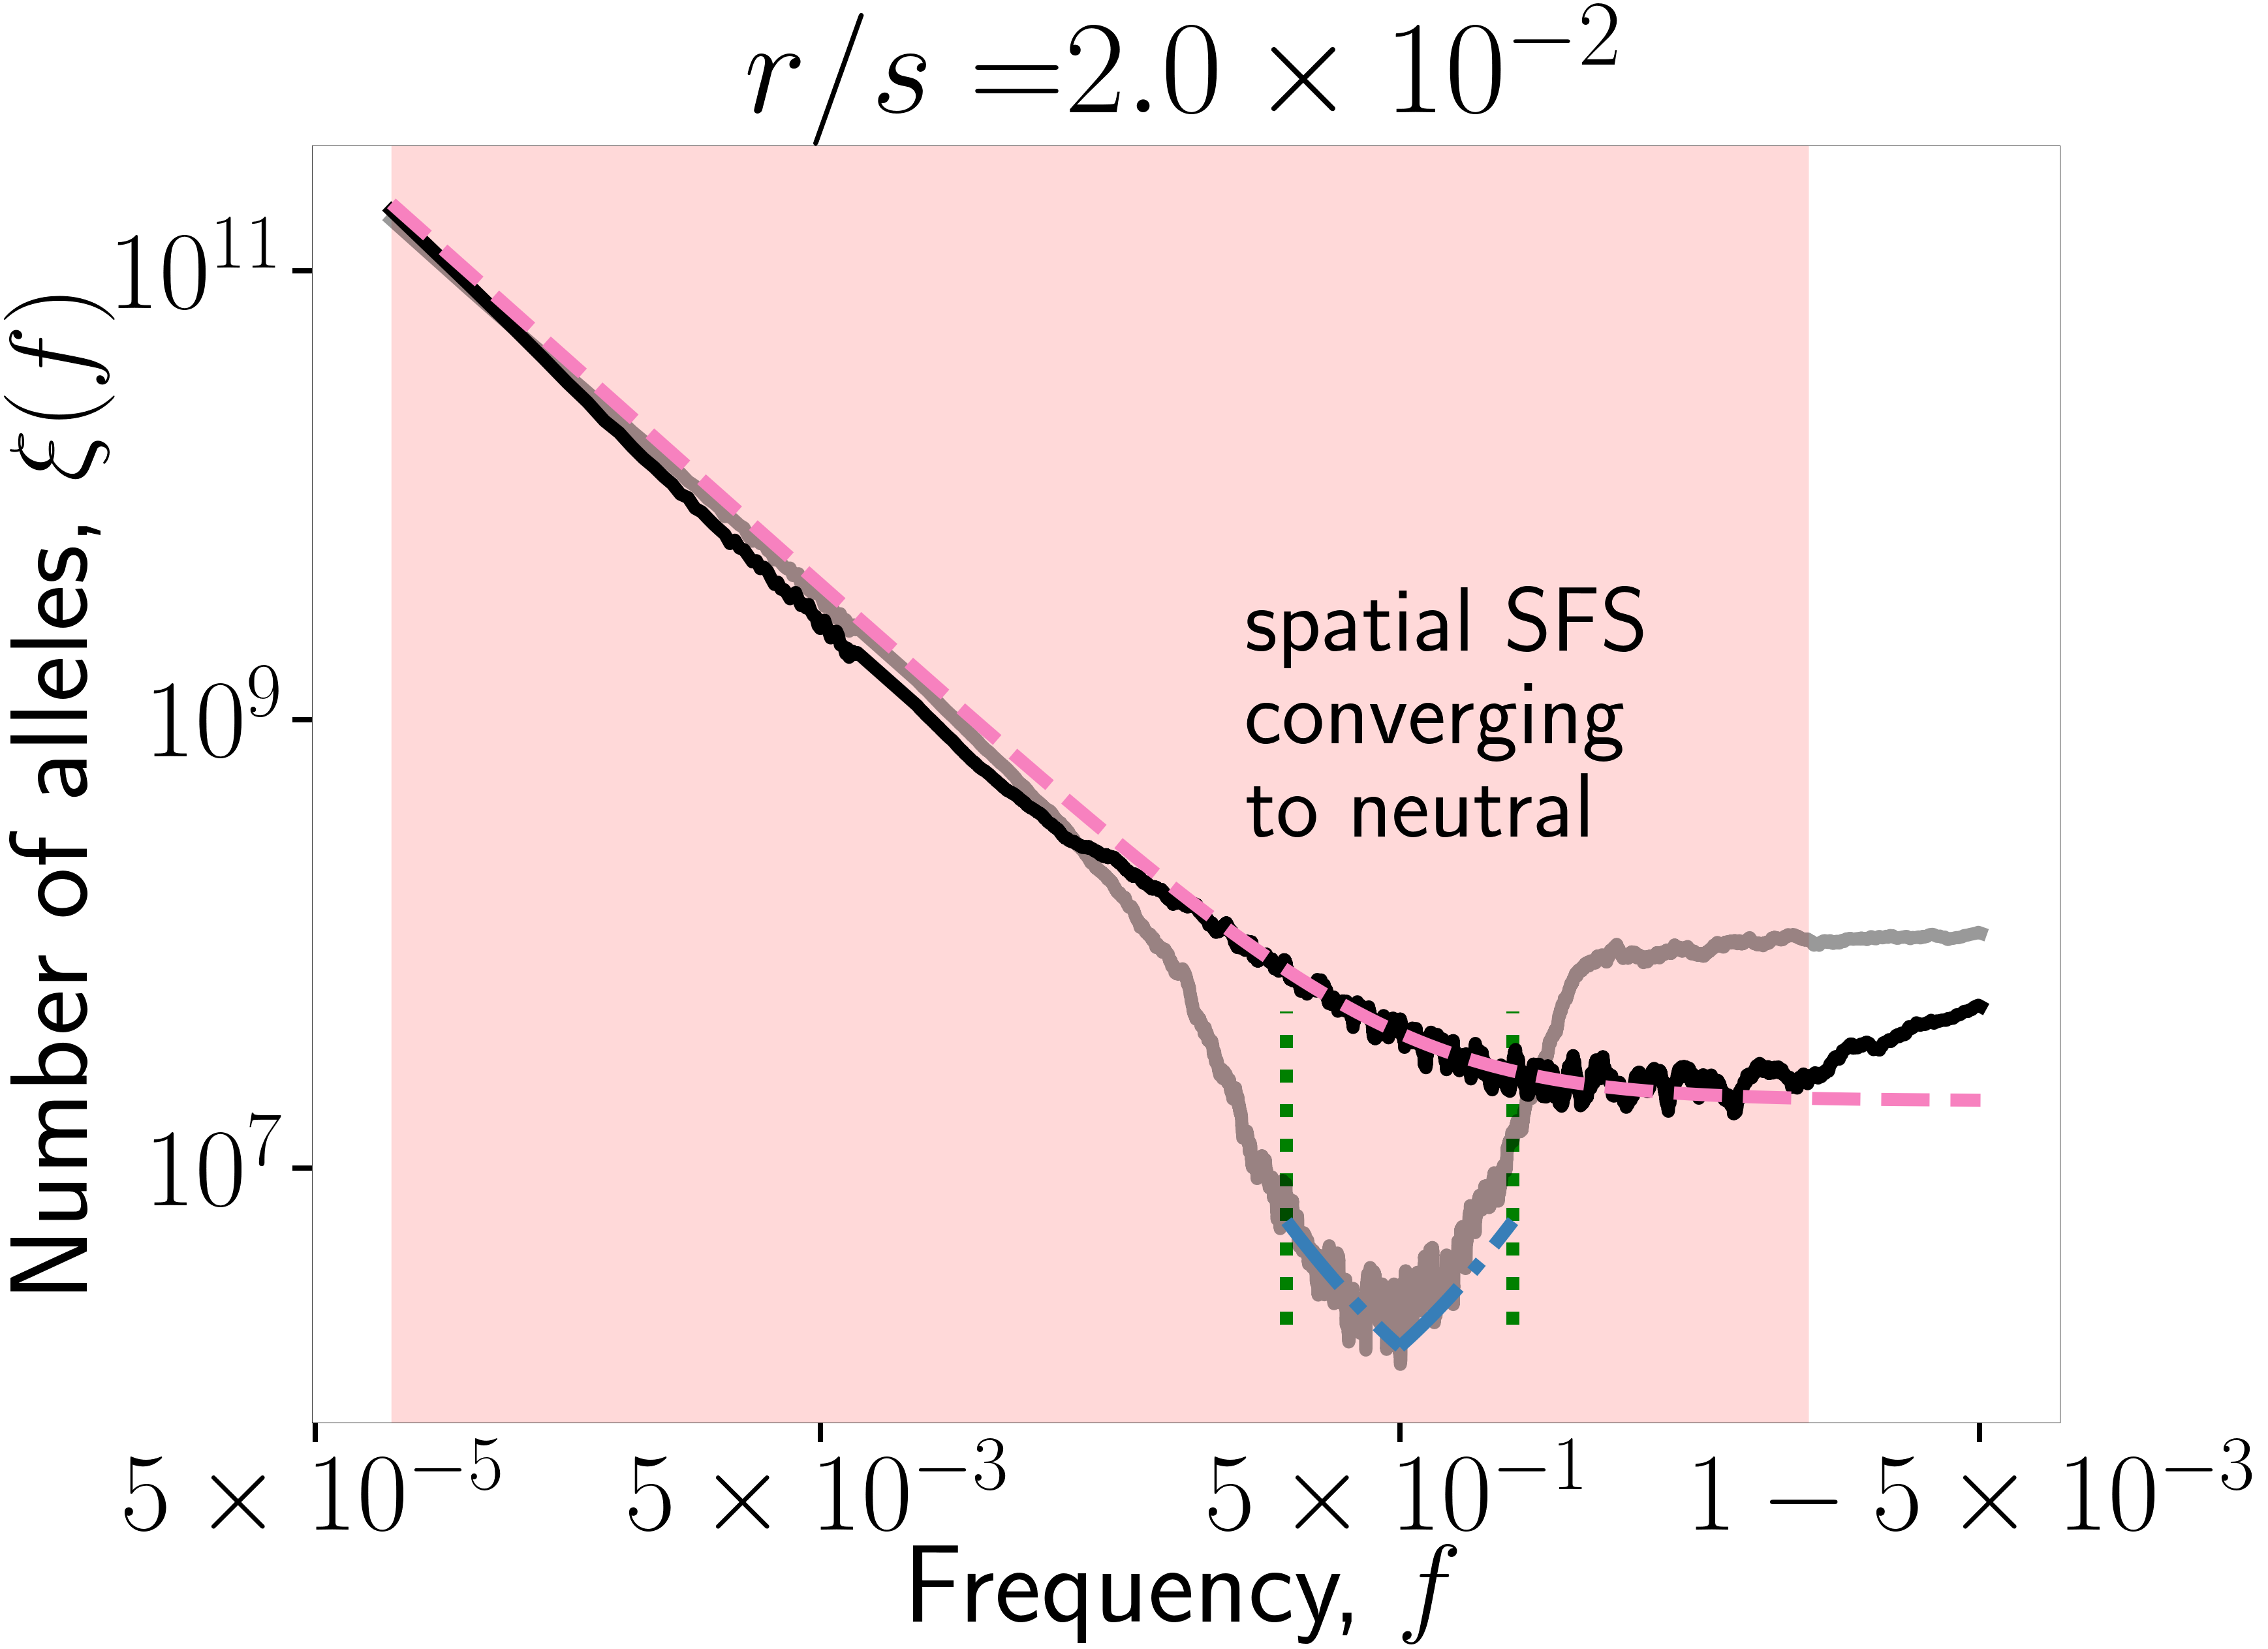

In [62]:
# Plot SFSs (1D and well-mixed), neutral asymptote, and non-neutral asymptotes

fig, ax = plt.subplots(figsize = (48, 36));
ax.set_xlabel(r'Frequency, $f$')
ax.set_ylabel(r'Number of alleles, $\xi(f)$')
ax.set_title(r'$r / s = $' + sci_notation(r / s))

ax.semilogy(logit(f_short_1d), moving_average(SFS_1d, 
                  window_size_1d, smooth_start_1d), color = 'k')
ax.semilogy(logit(f_short_wellmixed), moving_average(SFS_well_mixed,
                 window_size_wellmixed, smooth_start_wellmixed), 
            alpha = 0.4, color = 'k')
ax.semilogy(logit(f_short_1d), 2 * N / f_short_1d, 
                 linestyle = '--', 
                 color = '#f781bf')

ax.semilogy(logit(f_BSC_left_wellmixed), 
                  (1 + 2 * N * r) / s / f_BSC_left_wellmixed ** 2, 
                  linestyle = '-.', 
                  label = r'$U_\mathrm{n, eff} / s f^2$', 
                  color = '#377eb8')

ax.semilogy(logit(f_BSC_right_wellmixed), 
                  (2 * N * r) / s / (1 - f_BSC_right_wellmixed) ** 2, 
                  linestyle = '-.',  
                  color ='#377eb8', 
                  label = r'$(U_\mathrm{n, eff} - U_n) N r / s (1 - f)^2$')

ax.text(-1.4, 3 * 10 ** 8, 'spatial SFS \n converging \n to neutral', fontsize = 140)

ax.axvspan(logit(f_arrow_start), logit(f_arrow_end), alpha = 0.15, color = 'r')


ax.vlines(logit(np.log(N * s) * r / s), 2 * 10 ** 6, 5 * 10 ** 7, linestyle = 'dotted', color = 'g')
ax.vlines(-logit(np.log(N * s) * r / s), 2 * 10 ** 6, 5 * 10 ** 7, linestyle = 'dotted', color = 'g')
plt.xticks([logit(0.5 / 10 ** i) for i in np.arange(0, 5, 2)] 
           + [logit(1 - 0.5 / 10 ** i) for i in np.arange(2, 3, 2)], 
           [r'$5 \times 10^{{{}}}$'.format(- (i + 1)) for i in np.arange(0, 5, 2)]
          + [r'$1 - 5 \times 10^{{{}}}$'.format(- (i + 1)) for i in np.arange(2, 3, 2)])


#ax.legend(fontsize = 80, loc = 'lower left')

In [63]:
fig.savefig('sex_midhigh.pdf', format = 'pdf', bbox_inches = 'tight')

In [64]:
# 3)  r << v / L << lambda < s

r = 5 * 10 ** -3
nback_sim_1d = 1000

# Import the SFSs
SFS_1d = np.loadtxt('backward_simulation_data/expected_SFS_L=' 
    + '{}_N={}_s={:.3f}_m={:.2f}_r={:.2e}_nsample={}_t_after_fix={}_Nback={}_avged.txt'.format(L, 
             rho, s, m, r, n, T_after_fix, nback_sim_1d))

SFS_well_mixed = np.loadtxt(
            'backward_simulation_data/'
            + 'expected_SFS_well_mixed_N={}_Tfix={}_s={:.2f}_r={:.2e}_nsample={}_nsim={}.txt'.format(
                    N, T_after_fix, s, r, n, n_sim_well_mixed))



In [65]:

smooth_start_1d = 70
window_size_1d = 100
smooth_start_wellmixed = 70
window_size_wellmixed = 100

f = np.arange(1 / n, 1 + 1 / n, 1 / n)
f_short_1d = moving_average(f, window_size_1d, smooth_start_1d)
SFS_1d_smooth = moving_average(SFS_1d, window_size_1d, smooth_start_1d)

f_short_wellmixed = moving_average(f, window_size_wellmixed, smooth_start_wellmixed)


f_BSC_left = np.linspace(10 ** -2.8, 10 ** -1.2)
f_BSC_right = np.linspace(0.9, 0.995)
f_uniform = np.linspace(10 ** -1, 0.9)
f_BSC_left_wellmixed = np.linspace(np.log(N * s) * r / s, 0.5)
f_BSC_right_wellmixed = np.linspace(0.5, 1 - np.log(N * s) * r / s)

In [74]:
# Put arrows where the 1D SFS starts converging to neutral expected pattern. (start and end f)

f_arrow_start = 0.5
df = 5 / n
error_start = deviate_from_neutral(SFS_1d_smooth, 2 * N * Un / f_short_1d, f_arrow_start, df)

error_threshold = 0.5
while error_start < error_threshold:
    f_arrow_start -= df
    error_start = deviate_from_neutral(SFS_1d_smooth, 2 * N * Un / f_short_1d, f_arrow_start, df)

if f_arrow_start < df:
    f_arrow_start = 1 / n
f_arrow_end = 0.5
error_end = deviate_from_neutral(SFS_1d_smooth, 2 * N * Un / f_short_1d, f_arrow_end, df)

while error_end < error_threshold:
    f_arrow_end += df
    error_end = deviate_from_neutral(SFS_1d_smooth, 2 * N * Un / f_short_1d, f_arrow_end, df)
if f_arrow_end > 1 - df:
    f_arrow_end = 1 - 1 / n


C:\Users\jim903\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jim903\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


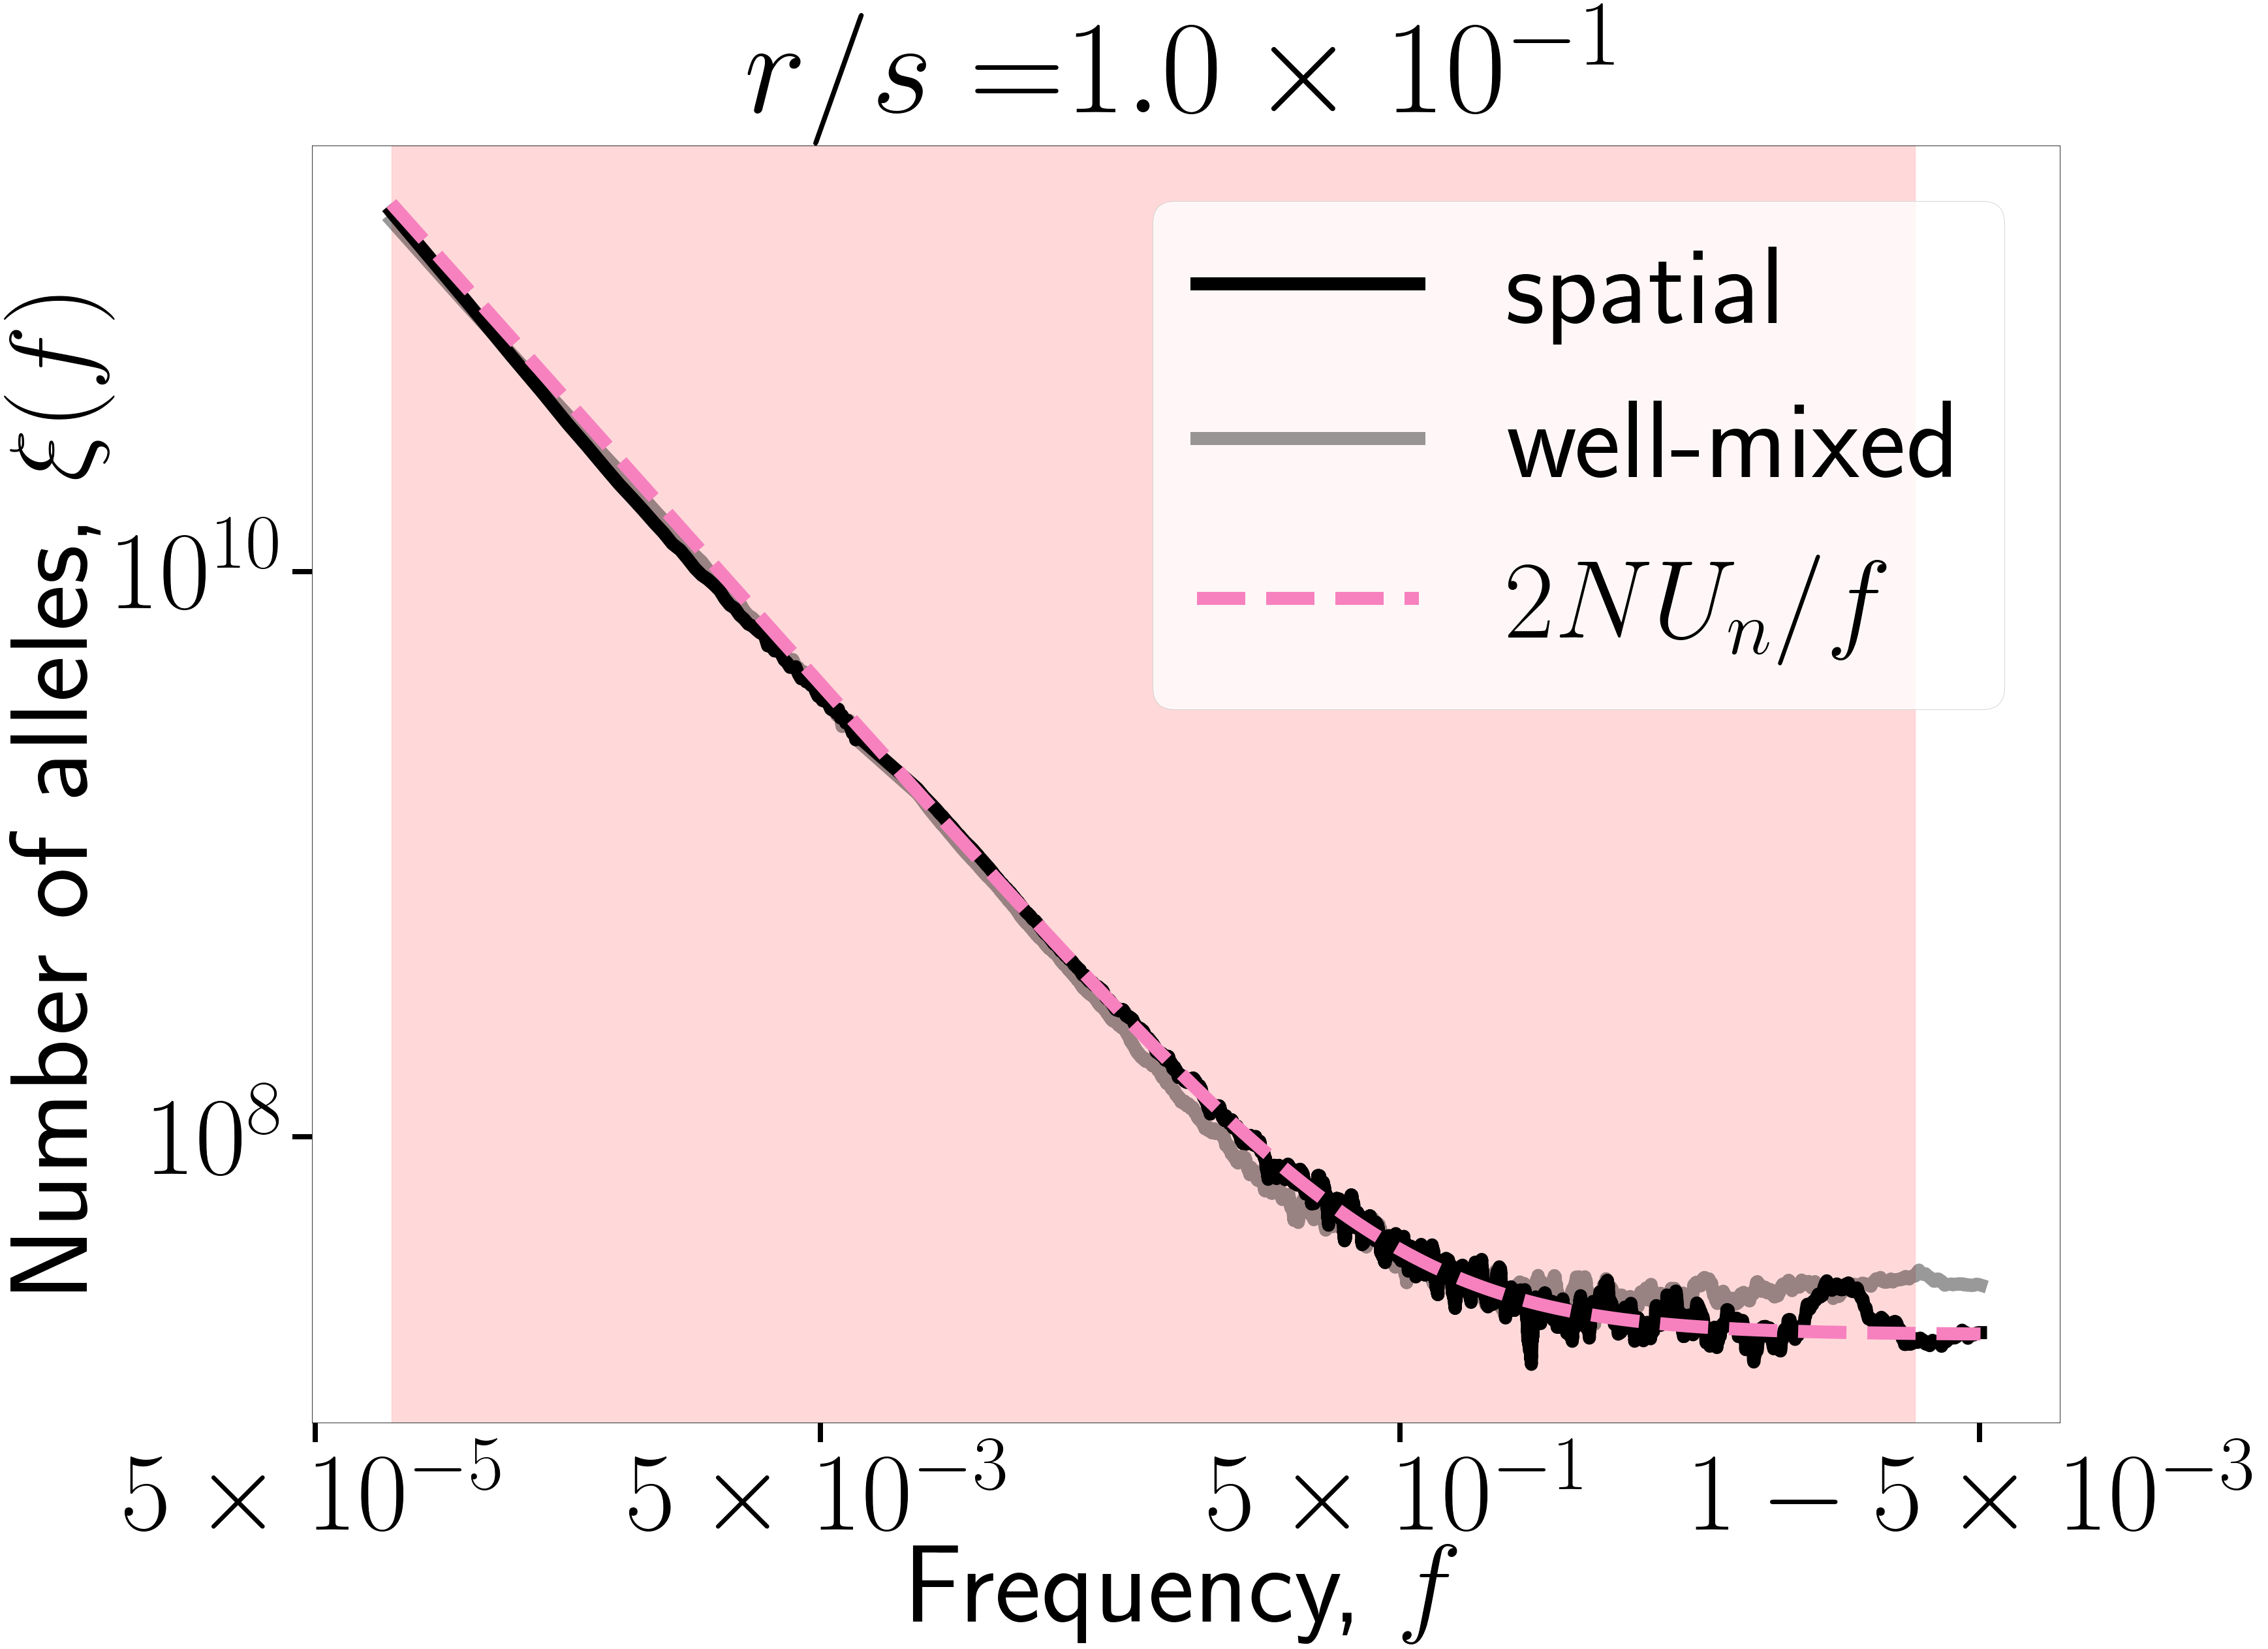

In [76]:
# Plot SFSs (1D and well-mixed) and neutral asymptote

fig, ax = plt.subplots(figsize = (48, 36));
ax.set_xlabel(r'Frequency, $f$')
ax.set_ylabel(r'Number of alleles, $\xi(f)$')
ax.set_title(r'$r / s = $' + sci_notation(r / s, exponent = -1))

ax.semilogy(logit(f_short_1d), moving_average(SFS_1d, 
                  window_size_1d, smooth_start_1d), 
        label = 'spatial'.format(r), color = 'k')
ax.semilogy(logit(f_short_wellmixed), moving_average(SFS_well_mixed,
                 window_size_wellmixed, smooth_start_wellmixed), 
             alpha = 0.4, color = 'k', label = 'well-mixed')
ax.semilogy(logit(f_short_1d), 2 * N / f_short_1d, 
                 linestyle = '--', label = r'$2 N U_n / f$', 
                 color = '#f781bf')
ax.axvspan(logit(f_arrow_start), logit(f_arrow_end), alpha = 0.15, color = 'r')
plt.xticks([logit(0.5 / 10 ** i) for i in np.arange(0, 5, 2)] 
           + [logit(1 - 0.5 / 10 ** i) for i in np.arange(2, 3, 2)], 
           [r'$5 \times 10^{{{}}}$'.format(- (i + 1)) for i in np.arange(0, 5, 2)]
          + [r'$1 - 5 \times 10^{{{}}}$'.format(- (i + 1)) for i in np.arange(2, 3, 2)])

ax.legend()

In [77]:
fig.savefig('sex_high.pdf', format = 'pdf', bbox_inches = 'tight')

In [78]:
# Plot SFS with uniformly distributed origin

# define parameters

L = 5001
rho = 200
s = 0.05
m = 0.25
tfinal = 100000
Un = 1
r = 0
n_forward = 5
tfix = 0
dx = 250

l0list = np.arange(0, L, dx)

n = 100000
nSFS = 1000

N = L * rho

f = np.arange(1, n + 1) / n
navg = 60
start_smooth = 100
f_short = moving_average(f, navg, start_smooth)


In [79]:

# Find v from lines
l0 = 0
freq_file = open(
   'forward_simulation_data/L={}_N={}_s={:.6f}_m={:.6f}_tfinal={}_l0={}_0.txt'.format(L, rho, s, m, tfinal, l0))
lines = np.loadtxt(freq_file, dtype=np.int64)
tf_real = len(lines)
v_list = []
for t in np.arange(int(tf_real / 4), int(tf_real * 3 / 4)):
    line1 = lines[t]
    line2 = lines[t + 1]
    psum1 = sum(line1) / rho
    psum2 = sum(line2) / rho
    v_list.append(psum2 - psum1)

v = np.average(v_list)

# If it takes too long to load the forward file
v = 0.12549022078838593

KeyboardInterrupt: 

In [183]:
# import SFS
l0 = 5000
SFS = np.loadtxt('backward_simulation_data/expected_SFS_L={}_N={}_s={:.6f}_m={:.6f}_r={:.6f}_tfinal={}_nsample={}_tfix={}_l0={}_navg={}_avged.txt'.format(L, 
    rho, s, m, r, tfinal, n, tfix, l0, nSFS))
SFS_smooth = moving_average(SFS, navg, start_smooth)

Text(0.2, 42000, '$\\boldmath{2 U_n L (1 - f) / v}$')

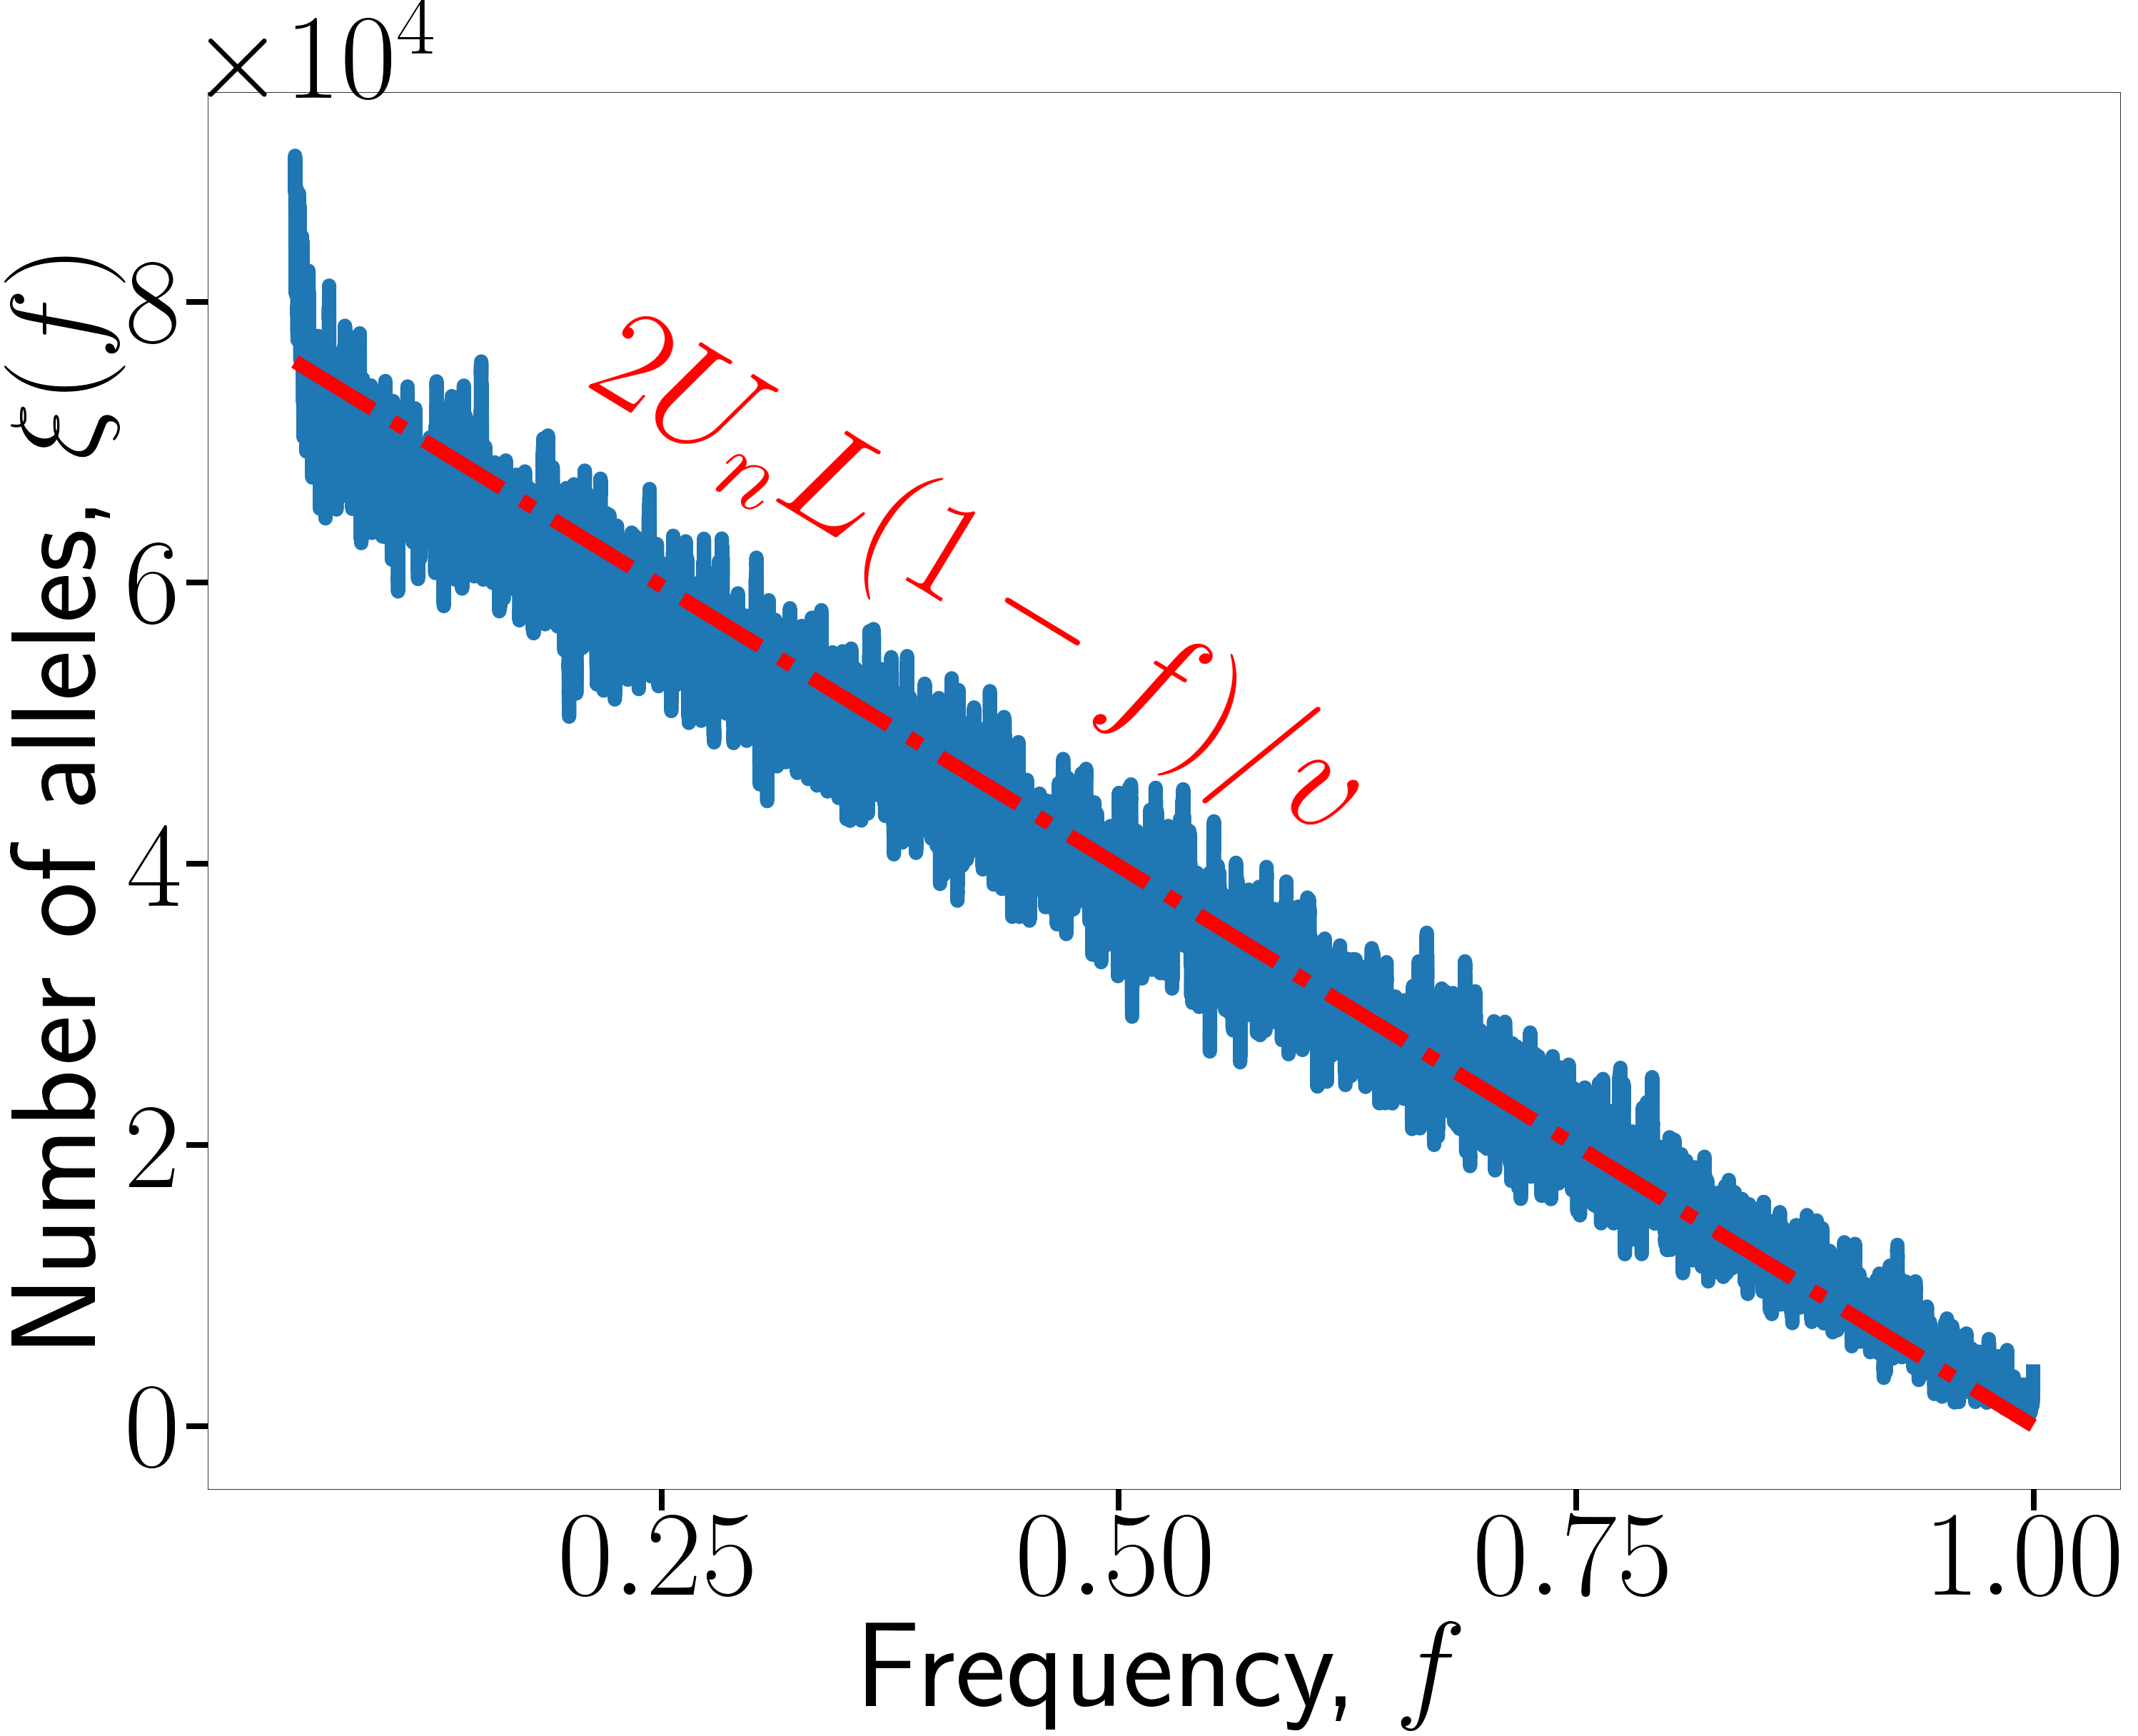

In [202]:
# Plot

fig, ax = plt.subplots(figsize = (48, 36));
ax.set_xlabel(r'Frequency, $f$')
ax.set_ylabel(r'Number of alleles, $\xi(f)$')
ax.ticklabel_format(style = 'sci', axis = 'y', scilimits = (0, 0))
ax.plot(f_short[-95000:], 
             SFS_smooth[-95000:], 
             linewidth = 20)
ax.plot(f_short[-95000:], 2 * Un * (1 - f_short[-95000:]) * L / v, linewidth = 20, 
           linestyle = '-.', color = 'r'
              , label = r'$2 U_n L (1 - f) / v$')

ax.text(0.2, 42000, r'$\boldmath{2 U_n L (1 - f) / v}$', 
                                   fontsize = 200, rotation = -31.3, color = 'r')

In [203]:
fig.savefig('different_tail.pdf', format = 'pdf', bbox_inches = 'tight')